# Classification non-supervisée des armures textiles à partir du modèle VGG16

https://datascientest.com/quest-ce-que-le-modele-vgg --> VGG16 : convolution sur des images 224x224, entraîné sur ImageNet (ensemble d'images). But : prétraitement et _finetuning_ en utilisant les poids de l'entraînement sur ImageNet. 

Code réadapté à partir du travail de mémoire de Colin Prudhomme : https://github.com/MightyPotato9/M2_HN/blob/main/notebooks/clustering_forme.ipynb

__Étapes de travail__ :

- _Vector embedding_ : un vecteur pour chaque image, récupération des features d'un réseau de neurones classificateur pour chaque image
- Visualisation dans l'espace : UMAP
- Clustering : HDBSCAN / KMEAN

In [16]:
# Librairies classiques
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from tqdm import tqdm

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [17]:
# Chargement des images 
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from PIL import Image

In [18]:
# Modèle pour embedding
from keras.applications.vgg16 import VGG16 
from keras.models import Model

In [19]:
# Réduction de dimension et clustering
import umap.umap_ as umap
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from sklearn.cluster import KMeans
import hdbscan

In [5]:
cd ../../data

/Users/lise/memoire_tech/M2_HN/data


## Embedding des images

In [8]:
# Chemin vers les images
path = 'images/images_jpg'
os.chdir(path)

# Liste contenant les images
textiles = []

# Récupération du nom des images
with os.scandir() as files:
    for file in files:
        if file.name.endswith('.jpg') and not file.name.startswith('MEE'): 
            #Récupère seulement les images et suppression des maquettes (renseignées par MEE)
            textiles.append(file.name)
print(f"Nombre d'images : {len(textiles)}")

Nombre d'images2871


In [10]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
channels = [[0,0]]

#Création de la fonction qui permet de récupérer les _features_.
def extract_features(file, model):
    # chargement de l'image
    img = load_img(file, target_size=(224,224))
    img = np.array(img) 
    # Redimensionnement de l'image pour le modèle (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    imgx = preprocess_input(reshaped_img)
    # Récupération des features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [8]:
#Visualisation des composants du modèle
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
data = {}

#Extraction des features pour chaque image
for textile in tqdm(textiles):
    try:
        feat = extract_features(textile, model)
        data[textile] = feat
    except:
        pass

  0%|                                                  | 0/2871 [00:00<?, ?it/s]2024-05-30 16:24:25.221653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 692ms/step


  0%|                                        | 1/2871 [00:01<1:02:50,  1.31s/it]

1/1 [==============================] - 0s 16ms/step


  0%|                                          | 3/2871 [00:01<18:49,  2.54it/s]

1/1 [==============================] - 0s 13ms/step


  0%|                                          | 5/2871 [00:01<10:51,  4.40it/s]

1/1 [==============================] - 0s 13ms/step


  0%|                                          | 7/2871 [00:01<07:29,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                         | 9/2871 [00:01<05:46,  8.26it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                        | 11/2871 [00:01<04:40, 10.21it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                        | 13/2871 [00:02<03:59, 11.94it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▏                                        | 15/2871 [00:02<03:35, 13.24it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏                                        | 17/2871 [00:02<03:15, 14.62it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▎                                        | 19/2871 [00:02<03:05, 15.38it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▎                                        | 21/2871 [00:02<02:58, 16.00it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▎                                        | 23/2871 [00:02<02:48, 16.85it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▎                                        | 25/2871 [00:02<02:44, 17.35it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                        | 27/2871 [00:02<02:45, 17.15it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                        | 29/2871 [00:02<02:49, 16.81it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▍                                        | 31/2871 [00:03<02:42, 17.44it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▍                                        | 33/2871 [00:03<02:38, 17.89it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▍                                        | 35/2871 [00:03<02:36, 18.10it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                        | 37/2871 [00:03<02:36, 18.06it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                        | 39/2871 [00:03<02:37, 17.96it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                        | 41/2871 [00:03<02:39, 17.79it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                        | 43/2871 [00:03<02:43, 17.35it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▋                                        | 45/2871 [00:03<02:44, 17.14it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▋                                        | 47/2871 [00:03<02:44, 17.20it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▋                                        | 49/2871 [00:04<02:38, 17.82it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▋                                        | 51/2871 [00:04<02:38, 17.78it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▊                                        | 53/2871 [00:04<02:37, 17.84it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▊                                        | 55/2871 [00:04<02:51, 16.42it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▊                                        | 57/2871 [00:04<02:52, 16.36it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▊                                        | 59/2871 [00:04<02:48, 16.73it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▊                                        | 61/2871 [00:04<02:42, 17.32it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▉                                        | 63/2871 [00:04<02:38, 17.70it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▉                                        | 65/2871 [00:05<02:37, 17.85it/s]

1/1 [==============================] - 0s 11ms/step


  2%|▉                                        | 67/2871 [00:05<02:36, 17.97it/s]

1/1 [==============================] - 0s 11ms/step


  2%|▉                                        | 69/2871 [00:05<02:34, 18.17it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█                                        | 71/2871 [00:05<02:30, 18.60it/s]

1/1 [==============================] - 0s 11ms/step


  3%|█                                        | 73/2871 [00:05<02:34, 18.13it/s]

1/1 [==============================] - 0s 11ms/step


  3%|█                                        | 75/2871 [00:05<02:31, 18.41it/s]

1/1 [==============================] - 0s 12ms/step


  3%|█                                        | 77/2871 [00:05<02:31, 18.49it/s]

1/1 [==============================] - 0s 11ms/step


  3%|█▏                                       | 79/2871 [00:05<02:29, 18.67it/s]

1/1 [==============================] - 0s 12ms/step


  3%|█▏                                       | 81/2871 [00:05<02:27, 18.97it/s]

1/1 [==============================] - 0s 12ms/step


  3%|█▏                                       | 83/2871 [00:05<02:32, 18.24it/s]

1/1 [==============================] - 0s 11ms/step


  3%|█▏                                       | 85/2871 [00:06<02:31, 18.42it/s]

1/1 [==============================] - 0s 11ms/step


  3%|█▏                                       | 87/2871 [00:06<02:27, 18.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|█▎                                       | 90/2871 [00:06<02:24, 19.23it/s]

1/1 [==============================] - 0s 11ms/step


  3%|█▎                                       | 93/2871 [00:06<02:22, 19.53it/s]

1/1 [==============================] - 0s 11ms/step


  3%|█▎                                       | 95/2871 [00:06<02:24, 19.23it/s]

1/1 [==============================] - 0s 12ms/step


  3%|█▍                                       | 97/2871 [00:06<02:28, 18.68it/s]

1/1 [==============================] - 0s 12ms/step


  3%|█▍                                       | 99/2871 [00:06<02:31, 18.28it/s]

1/1 [==============================] - 0s 12ms/step


  4%|█▍                                      | 101/2871 [00:06<02:30, 18.40it/s]

1/1 [==============================] - 0s 12ms/step


  4%|█▍                                      | 103/2871 [00:07<02:29, 18.48it/s]

1/1 [==============================] - 0s 12ms/step


  4%|█▍                                      | 105/2871 [00:07<02:29, 18.47it/s]

1/1 [==============================] - 0s 11ms/step


  4%|█▍                                      | 107/2871 [00:07<02:29, 18.48it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 109/2871 [00:07<02:44, 16.74it/s]

1/1 [==============================] - 0s 13ms/step


  4%|█▌                                      | 111/2871 [00:07<03:03, 15.07it/s]

1/1 [==============================] - 0s 12ms/step


  4%|█▌                                      | 113/2871 [00:07<02:57, 15.56it/s]

1/1 [==============================] - 0s 12ms/step


  4%|█▌                                      | 115/2871 [00:07<02:52, 15.97it/s]

1/1 [==============================] - 0s 14ms/step


  4%|█▋                                      | 117/2871 [00:07<02:54, 15.80it/s]

1/1 [==============================] - 0s 13ms/step


  4%|█▋                                      | 119/2871 [00:08<02:59, 15.36it/s]

1/1 [==============================] - 0s 13ms/step


  4%|█▋                                      | 121/2871 [00:08<02:52, 15.93it/s]

1/1 [==============================] - 0s 13ms/step


  4%|█▋                                      | 123/2871 [00:08<02:48, 16.30it/s]

1/1 [==============================] - 0s 11ms/step


  4%|█▋                                      | 125/2871 [00:08<02:45, 16.61it/s]

1/1 [==============================] - 0s 12ms/step


  4%|█▊                                      | 127/2871 [00:08<02:37, 17.37it/s]

1/1 [==============================] - 0s 12ms/step


  4%|█▊                                      | 129/2871 [00:08<02:34, 17.76it/s]

1/1 [==============================] - 0s 12ms/step


  5%|█▊                                      | 131/2871 [00:08<02:32, 18.02it/s]

1/1 [==============================] - 0s 12ms/step


  5%|█▊                                      | 133/2871 [00:08<02:29, 18.30it/s]

1/1 [==============================] - 0s 12ms/step


  5%|█▉                                      | 135/2871 [00:08<02:26, 18.61it/s]

1/1 [==============================] - 0s 12ms/step


  5%|█▉                                      | 137/2871 [00:09<02:27, 18.57it/s]

1/1 [==============================] - 0s 11ms/step


  5%|█▉                                      | 139/2871 [00:09<02:25, 18.83it/s]

1/1 [==============================] - 0s 12ms/step


  5%|█▉                                      | 142/2871 [00:09<02:05, 21.78it/s]

1/1 [==============================] - 0s 14ms/step


  5%|██                                      | 145/2871 [00:09<02:13, 20.39it/s]

1/1 [==============================] - 0s 13ms/step


  5%|██                                      | 148/2871 [00:09<02:19, 19.56it/s]

1/1 [==============================] - 0s 13ms/step


  5%|██                                      | 150/2871 [00:09<02:21, 19.17it/s]

1/1 [==============================] - 0s 13ms/step


  5%|██                                      | 152/2871 [00:09<02:22, 19.04it/s]

1/1 [==============================] - 0s 13ms/step


  5%|██▏                                     | 154/2871 [00:09<02:24, 18.76it/s]

1/1 [==============================] - 0s 12ms/step


  5%|██▏                                     | 156/2871 [00:10<02:25, 18.72it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▏                                     | 158/2871 [00:10<02:26, 18.49it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▏                                     | 160/2871 [00:10<02:26, 18.53it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▎                                     | 162/2871 [00:10<02:26, 18.45it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▎                                     | 164/2871 [00:10<02:25, 18.60it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▎                                     | 166/2871 [00:10<02:23, 18.87it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▎                                     | 168/2871 [00:10<02:21, 19.05it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▎                                     | 170/2871 [00:10<02:26, 18.49it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▍                                     | 172/2871 [00:10<02:28, 18.17it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▍                                     | 174/2871 [00:11<02:26, 18.44it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▍                                     | 176/2871 [00:11<02:24, 18.63it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▍                                     | 178/2871 [00:11<02:32, 17.67it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▌                                     | 180/2871 [00:11<02:27, 18.21it/s]

1/1 [==============================] - 0s 12ms/step


  6%|██▌                                     | 182/2871 [00:11<02:27, 18.24it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▌                                     | 184/2871 [00:11<02:25, 18.50it/s]

1/1 [==============================] - 0s 11ms/step


  6%|██▌                                     | 186/2871 [00:11<02:25, 18.51it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██▌                                     | 188/2871 [00:11<02:27, 18.24it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██▋                                     | 190/2871 [00:11<02:27, 18.22it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██▋                                     | 192/2871 [00:11<02:25, 18.36it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██▋                                     | 194/2871 [00:12<02:25, 18.43it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██▋                                     | 196/2871 [00:12<02:21, 18.84it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██▊                                     | 198/2871 [00:12<02:20, 19.00it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 200/2871 [00:12<02:25, 18.34it/s]

1/1 [==============================] - 0s 14ms/step


  7%|██▊                                     | 202/2871 [00:12<02:29, 17.79it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 204/2871 [00:12<02:33, 17.32it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 206/2871 [00:12<02:35, 17.19it/s]

1/1 [==============================] - 0s 14ms/step


  7%|██▉                                     | 208/2871 [00:12<02:41, 16.52it/s]

1/1 [==============================] - 0s 12ms/step


  7%|██▉                                     | 211/2871 [00:13<02:17, 19.41it/s]

1/1 [==============================] - 0s 13ms/step


  7%|██▉                                     | 213/2871 [00:13<02:25, 18.28it/s]

1/1 [==============================] - 0s 14ms/step


  7%|██▉                                     | 215/2871 [00:13<02:26, 18.08it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███                                     | 217/2871 [00:13<02:24, 18.37it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███                                     | 219/2871 [00:13<02:24, 18.37it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███                                     | 221/2871 [00:13<02:22, 18.53it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███                                     | 223/2871 [00:13<02:22, 18.64it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███▏                                    | 225/2871 [00:13<02:26, 18.04it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███▏                                    | 227/2871 [00:13<02:29, 17.70it/s]

1/1 [==============================] - 0s 13ms/step


  8%|███▏                                    | 229/2871 [00:14<02:33, 17.26it/s]

1/1 [==============================] - 0s 13ms/step


  8%|███▏                                    | 231/2871 [00:14<02:31, 17.43it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███▏                                    | 233/2871 [00:14<02:28, 17.77it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███▎                                    | 235/2871 [00:14<02:28, 17.80it/s]

1/1 [==============================] - 0s 13ms/step


  8%|███▎                                    | 237/2871 [00:14<02:30, 17.49it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███▎                                    | 239/2871 [00:14<02:33, 17.14it/s]

1/1 [==============================] - 0s 12ms/step


  8%|███▎                                    | 242/2871 [00:14<02:13, 19.73it/s]

1/1 [==============================] - 0s 13ms/step


  8%|███▍                                    | 244/2871 [00:14<02:20, 18.65it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███▍                                    | 246/2871 [00:14<02:24, 18.14it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███▍                                    | 248/2871 [00:15<02:25, 18.04it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███▍                                    | 250/2871 [00:15<02:26, 17.84it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███▌                                    | 252/2871 [00:15<02:28, 17.59it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███▌                                    | 254/2871 [00:15<02:34, 16.97it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███▌                                    | 256/2871 [00:15<02:33, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███▌                                    | 258/2871 [00:15<02:31, 17.23it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███▌                                    | 260/2871 [00:15<02:29, 17.41it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▋                                    | 262/2871 [00:15<02:39, 16.36it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▋                                    | 264/2871 [00:16<02:39, 16.32it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███▋                                    | 266/2871 [00:16<02:41, 16.10it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███▋                                    | 268/2871 [00:16<02:43, 15.94it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███▊                                    | 270/2871 [00:16<02:37, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███▊                                    | 272/2871 [00:16<02:34, 16.78it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███▊                                    | 274/2871 [00:16<02:34, 16.77it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███▊                                    | 276/2871 [00:16<02:37, 16.46it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███▊                                    | 278/2871 [00:16<02:34, 16.73it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███▉                                    | 280/2871 [00:17<02:30, 17.22it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███▉                                    | 282/2871 [00:17<02:28, 17.46it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███▉                                    | 284/2871 [00:17<02:27, 17.58it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███▉                                    | 286/2871 [00:17<02:28, 17.38it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████                                    | 288/2871 [00:17<02:27, 17.53it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████                                    | 290/2871 [00:17<02:27, 17.55it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████                                    | 292/2871 [00:17<02:30, 17.18it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████                                    | 294/2871 [00:17<02:27, 17.47it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████                                    | 296/2871 [00:17<02:26, 17.54it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████▏                                   | 298/2871 [00:18<02:28, 17.36it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████▏                                   | 300/2871 [00:18<02:28, 17.28it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▏                                   | 302/2871 [00:18<02:56, 14.56it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▏                                   | 304/2871 [00:18<02:53, 14.84it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████▎                                   | 306/2871 [00:18<02:46, 15.37it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████▎                                   | 308/2871 [00:18<02:38, 16.13it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████▎                                   | 311/2871 [00:18<02:16, 18.76it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████▎                                   | 313/2871 [00:18<02:17, 18.54it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████▍                                   | 315/2871 [00:19<02:16, 18.66it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████▍                                   | 317/2871 [00:19<02:20, 18.21it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████▍                                   | 319/2871 [00:19<02:23, 17.84it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████▍                                   | 321/2871 [00:19<02:23, 17.78it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████▌                                   | 323/2871 [00:19<02:20, 18.08it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████▌                                   | 325/2871 [00:19<02:20, 18.15it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████▌                                   | 327/2871 [00:19<02:22, 17.83it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▌                                   | 329/2871 [00:19<02:28, 17.13it/s]

1/1 [==============================] - 0s 13ms/step


 12%|████▌                                   | 331/2871 [00:19<02:29, 17.04it/s]

1/1 [==============================] - 0s 13ms/step


 12%|████▋                                   | 333/2871 [00:20<02:26, 17.33it/s]

1/1 [==============================] - 0s 12ms/step


 12%|████▋                                   | 335/2871 [00:20<02:24, 17.55it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▋                                   | 337/2871 [00:20<02:28, 17.09it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▋                                   | 339/2871 [00:20<02:35, 16.24it/s]

1/1 [==============================] - 0s 13ms/step


 12%|████▊                                   | 341/2871 [00:20<02:32, 16.57it/s]

1/1 [==============================] - 0s 13ms/step


 12%|████▊                                   | 343/2871 [00:20<02:26, 17.23it/s]

1/1 [==============================] - 0s 14ms/step


 12%|████▊                                   | 345/2871 [00:20<02:25, 17.37it/s]

1/1 [==============================] - 0s 13ms/step


 12%|████▊                                   | 347/2871 [00:20<02:27, 17.13it/s]

1/1 [==============================] - 0s 13ms/step


 12%|████▊                                   | 349/2871 [00:21<02:28, 17.02it/s]

1/1 [==============================] - 0s 12ms/step


 12%|████▉                                   | 351/2871 [00:21<02:30, 16.69it/s]

1/1 [==============================] - 0s 12ms/step


 12%|████▉                                   | 354/2871 [00:21<02:08, 19.56it/s]

1/1 [==============================] - 0s 12ms/step


 12%|████▉                                   | 356/2871 [00:21<02:17, 18.29it/s]

1/1 [==============================] - 0s 12ms/step


 12%|████▉                                   | 358/2871 [00:21<02:18, 18.13it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████                                   | 360/2871 [00:21<02:17, 18.20it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████                                   | 362/2871 [00:21<02:20, 17.84it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████                                   | 364/2871 [00:21<02:23, 17.42it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████                                   | 366/2871 [00:21<02:26, 17.15it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████▏                                  | 368/2871 [00:22<02:25, 17.20it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▏                                  | 370/2871 [00:22<02:24, 17.29it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▏                                  | 372/2871 [00:22<02:21, 17.69it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▏                                  | 374/2871 [00:22<02:23, 17.39it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█████▏                                  | 376/2871 [00:22<02:28, 16.79it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▎                                  | 378/2871 [00:22<02:26, 16.98it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▎                                  | 380/2871 [00:22<02:25, 17.07it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▎                                  | 382/2871 [00:22<02:26, 16.96it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▎                                  | 384/2871 [00:23<02:28, 16.79it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████▍                                  | 386/2871 [00:23<02:25, 17.10it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█████▍                                  | 388/2871 [00:23<02:22, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▍                                  | 390/2871 [00:23<02:37, 15.71it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█████▍                                  | 392/2871 [00:23<02:51, 14.46it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█████▍                                  | 394/2871 [00:23<02:44, 15.03it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█████▌                                  | 396/2871 [00:23<02:38, 15.57it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█████▌                                  | 398/2871 [00:23<02:35, 15.90it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█████▌                                  | 400/2871 [00:24<02:33, 16.05it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█████▌                                  | 402/2871 [00:24<02:30, 16.45it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█████▋                                  | 404/2871 [00:24<02:29, 16.53it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█████▋                                  | 406/2871 [00:24<02:27, 16.70it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█████▋                                  | 408/2871 [00:24<02:23, 17.11it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█████▋                                  | 410/2871 [00:24<02:22, 17.29it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█████▋                                  | 412/2871 [00:24<02:22, 17.22it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█████▊                                  | 414/2871 [00:24<02:19, 17.57it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█████▊                                  | 416/2871 [00:24<02:18, 17.72it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█████▊                                  | 418/2871 [00:25<02:18, 17.71it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█████▊                                  | 421/2871 [00:25<02:00, 20.30it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█████▉                                  | 424/2871 [00:25<02:04, 19.62it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█████▉                                  | 426/2871 [00:25<02:08, 18.97it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█████▉                                  | 428/2871 [00:25<02:09, 18.89it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█████▉                                  | 430/2871 [00:25<02:14, 18.18it/s]

1/1 [==============================] - 0s 13ms/step


 15%|██████                                  | 432/2871 [00:25<02:13, 18.24it/s]

1/1 [==============================] - 0s 14ms/step


 15%|██████                                  | 434/2871 [00:25<02:14, 18.10it/s]

1/1 [==============================] - 0s 13ms/step


 15%|██████                                  | 436/2871 [00:26<02:15, 17.95it/s]

1/1 [==============================] - 0s 14ms/step


 15%|██████                                  | 438/2871 [00:26<02:18, 17.55it/s]

1/1 [==============================] - 0s 13ms/step


 15%|██████▏                                 | 441/2871 [00:26<02:00, 20.10it/s]

1/1 [==============================] - 0s 12ms/step


 15%|██████▏                                 | 444/2871 [00:26<02:07, 18.96it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▏                                 | 446/2871 [00:26<02:09, 18.70it/s]

1/1 [==============================] - 0s 14ms/step


 16%|██████▏                                 | 448/2871 [00:26<02:12, 18.33it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▎                                 | 450/2871 [00:26<02:14, 18.00it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▎                                 | 452/2871 [00:26<02:15, 17.90it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▎                                 | 454/2871 [00:27<02:22, 16.93it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▎                                 | 456/2871 [00:27<02:25, 16.58it/s]

1/1 [==============================] - 0s 12ms/step


 16%|██████▍                                 | 458/2871 [00:27<02:28, 16.29it/s]

1/1 [==============================] - 0s 12ms/step


 16%|██████▍                                 | 460/2871 [00:27<02:28, 16.22it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▍                                 | 462/2871 [00:27<02:26, 16.40it/s]

1/1 [==============================] - 0s 15ms/step


 16%|██████▍                                 | 464/2871 [00:27<02:23, 16.74it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▍                                 | 466/2871 [00:27<02:22, 16.84it/s]

1/1 [==============================] - 0s 13ms/step


 16%|██████▌                                 | 468/2871 [00:27<02:20, 17.12it/s]

1/1 [==============================] - 0s 12ms/step


 16%|██████▌                                 | 471/2871 [00:27<02:02, 19.66it/s]

1/1 [==============================] - 0s 12ms/step


 16%|██████▌                                 | 473/2871 [00:28<02:04, 19.21it/s]

1/1 [==============================] - 0s 12ms/step


 17%|██████▌                                 | 475/2871 [00:28<02:09, 18.47it/s]

1/1 [==============================] - 0s 12ms/step


 17%|██████▋                                 | 477/2871 [00:28<02:14, 17.77it/s]

1/1 [==============================] - 0s 12ms/step


 17%|██████▋                                 | 479/2871 [00:28<02:16, 17.58it/s]

1/1 [==============================] - 0s 12ms/step


 17%|██████▋                                 | 481/2871 [00:28<02:16, 17.46it/s]

1/1 [==============================] - 0s 13ms/step


 17%|██████▋                                 | 483/2871 [00:28<02:16, 17.56it/s]

1/1 [==============================] - 0s 14ms/step


 17%|██████▊                                 | 485/2871 [00:28<02:16, 17.48it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▊                                 | 487/2871 [00:28<02:18, 17.27it/s]

1/1 [==============================] - 0s 13ms/step


 17%|██████▊                                 | 489/2871 [00:29<02:17, 17.30it/s]

1/1 [==============================] - 0s 13ms/step


 17%|██████▊                                 | 491/2871 [00:29<02:17, 17.29it/s]

1/1 [==============================] - 0s 13ms/step


 17%|██████▊                                 | 493/2871 [00:29<02:18, 17.14it/s]

1/1 [==============================] - 0s 14ms/step


 17%|██████▉                                 | 495/2871 [00:29<02:18, 17.11it/s]

1/1 [==============================] - 0s 13ms/step


 17%|██████▉                                 | 497/2871 [00:29<02:17, 17.21it/s]

1/1 [==============================] - 0s 12ms/step


 17%|██████▉                                 | 499/2871 [00:29<02:14, 17.67it/s]

1/1 [==============================] - 0s 13ms/step


 17%|██████▉                                 | 501/2871 [00:29<02:14, 17.65it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████                                 | 503/2871 [00:29<02:16, 17.32it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████                                 | 505/2871 [00:29<02:20, 16.85it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████                                 | 507/2871 [00:30<02:15, 17.47it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████                                 | 509/2871 [00:30<02:14, 17.54it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████                                 | 511/2871 [00:30<02:13, 17.66it/s]

1/1 [==============================] - 0s 14ms/step


 18%|███████▏                                | 513/2871 [00:30<02:18, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████▏                                | 515/2871 [00:30<02:18, 16.96it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████▏                                | 517/2871 [00:30<02:14, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                                | 519/2871 [00:30<02:18, 17.01it/s]

1/1 [==============================] - 0s 15ms/step


 18%|███████▎                                | 521/2871 [00:30<02:34, 15.16it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████▎                                | 523/2871 [00:31<02:30, 15.61it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████▎                                | 525/2871 [00:31<02:21, 16.60it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████▎                                | 527/2871 [00:31<02:15, 17.24it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▎                                | 529/2871 [00:31<02:20, 16.73it/s]

1/1 [==============================] - 0s 13ms/step


 18%|███████▍                                | 531/2871 [00:31<02:20, 16.61it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████▍                                | 533/2871 [00:31<02:20, 16.66it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████▍                                | 535/2871 [00:31<02:16, 17.16it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████▍                                | 537/2871 [00:31<02:16, 17.10it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████▌                                | 539/2871 [00:31<02:22, 16.35it/s]

1/1 [==============================] - 0s 18ms/step


 19%|███████▌                                | 541/2871 [00:32<02:29, 15.62it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████▌                                | 543/2871 [00:32<02:28, 15.70it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████▌                                | 545/2871 [00:32<02:23, 16.16it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████▌                                | 547/2871 [00:32<02:23, 16.20it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▋                                | 549/2871 [00:33<05:39,  6.85it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▋                                | 551/2871 [00:33<04:42,  8.20it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████▋                                | 553/2871 [00:33<03:57,  9.76it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████▋                                | 555/2871 [00:33<03:25, 11.26it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████▊                                | 557/2871 [00:33<03:06, 12.40it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████▊                                | 559/2871 [00:33<02:52, 13.42it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████▊                                | 561/2871 [00:33<02:43, 14.12it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████▊                                | 563/2871 [00:34<02:32, 15.12it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████▊                                | 565/2871 [00:34<02:27, 15.62it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████▉                                | 567/2871 [00:34<02:26, 15.71it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████▉                                | 569/2871 [00:34<02:21, 16.26it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████▉                                | 571/2871 [00:34<02:19, 16.52it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████▉                                | 573/2871 [00:34<02:16, 16.85it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████                                | 575/2871 [00:34<02:18, 16.59it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████                                | 577/2871 [00:34<02:14, 17.01it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████                                | 579/2871 [00:34<02:19, 16.39it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████                                | 581/2871 [00:35<02:26, 15.68it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████                                | 583/2871 [00:35<02:23, 15.99it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████▏                               | 585/2871 [00:35<02:21, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████▏                               | 587/2871 [00:35<02:18, 16.49it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████▏                               | 589/2871 [00:35<02:23, 15.94it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████▏                               | 591/2871 [00:35<02:20, 16.18it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▎                               | 593/2871 [00:35<02:27, 15.44it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                               | 595/2871 [00:36<02:27, 15.41it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████▎                               | 597/2871 [00:36<02:22, 15.92it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████▎                               | 599/2871 [00:36<02:19, 16.32it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████▎                               | 601/2871 [00:36<02:14, 16.82it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████▍                               | 603/2871 [00:36<02:16, 16.64it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████▍                               | 605/2871 [00:36<02:36, 14.43it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████▍                               | 607/2871 [00:36<02:30, 15.01it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████▍                               | 609/2871 [00:36<02:24, 15.62it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▌                               | 611/2871 [00:37<02:24, 15.65it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▌                               | 613/2871 [00:37<02:24, 15.66it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████▌                               | 615/2871 [00:37<02:22, 15.81it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▌                               | 617/2871 [00:37<02:21, 15.87it/s]

1/1 [==============================] - 0s 13ms/step


 22%|████████▌                               | 619/2871 [00:37<02:25, 15.43it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                               | 621/2871 [00:37<02:24, 15.54it/s]

1/1 [==============================] - 0s 14ms/step


 22%|████████▋                               | 623/2871 [00:37<02:21, 15.93it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                               | 625/2871 [00:37<02:22, 15.72it/s]

1/1 [==============================] - 0s 13ms/step


 22%|████████▋                               | 627/2871 [00:38<02:20, 15.92it/s]

1/1 [==============================] - 0s 13ms/step


 22%|████████▊                               | 629/2871 [00:38<02:18, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▊                               | 631/2871 [00:38<02:23, 15.59it/s]

1/1 [==============================] - 0s 14ms/step


 22%|████████▊                               | 633/2871 [00:38<02:19, 15.99it/s]

1/1 [==============================] - 0s 22ms/step


 22%|████████▊                               | 635/2871 [00:38<02:22, 15.74it/s]

1/1 [==============================] - 0s 14ms/step


 22%|████████▊                               | 637/2871 [00:38<02:29, 14.89it/s]

1/1 [==============================] - 0s 13ms/step


 22%|████████▉                               | 639/2871 [00:38<02:26, 15.25it/s]

1/1 [==============================] - 0s 13ms/step


 22%|████████▉                               | 641/2871 [00:38<02:23, 15.56it/s]

1/1 [==============================] - 0s 13ms/step


 22%|████████▉                               | 643/2871 [00:39<02:20, 15.89it/s]

1/1 [==============================] - 0s 14ms/step


 22%|████████▉                               | 645/2871 [00:39<02:17, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████                               | 647/2871 [00:39<02:14, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████                               | 649/2871 [00:39<02:12, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████                               | 651/2871 [00:39<02:10, 16.97it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████                               | 653/2871 [00:39<02:10, 16.98it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████▏                              | 655/2871 [00:39<02:09, 17.09it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████▏                              | 657/2871 [00:39<02:07, 17.31it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████▏                              | 659/2871 [00:39<02:11, 16.78it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████▏                              | 661/2871 [00:40<02:12, 16.71it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████▏                              | 663/2871 [00:40<02:09, 17.05it/s]

1/1 [==============================] - 0s 14ms/step


 23%|█████████▎                              | 665/2871 [00:40<02:08, 17.10it/s]

1/1 [==============================] - 0s 14ms/step


 23%|█████████▎                              | 667/2871 [00:40<02:10, 16.88it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████▎                              | 669/2871 [00:40<02:10, 16.86it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████▎                              | 671/2871 [00:40<02:12, 16.64it/s]

1/1 [==============================] - 0s 19ms/step


 23%|█████████▍                              | 673/2871 [00:40<02:17, 15.99it/s]

1/1 [==============================] - 0s 15ms/step


 24%|█████████▍                              | 675/2871 [00:40<02:20, 15.64it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▍                              | 677/2871 [00:41<02:22, 15.37it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▍                              | 679/2871 [00:41<02:17, 15.90it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▍                              | 681/2871 [00:41<02:13, 16.46it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▌                              | 683/2871 [00:41<02:08, 17.00it/s]

1/1 [==============================] - 0s 14ms/step


 24%|█████████▌                              | 685/2871 [00:41<02:10, 16.76it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▌                              | 687/2871 [00:41<02:11, 16.60it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▌                              | 689/2871 [00:41<02:08, 17.03it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▋                              | 691/2871 [00:41<02:06, 17.23it/s]

1/1 [==============================] - 0s 14ms/step


 24%|█████████▋                              | 693/2871 [00:42<02:08, 16.93it/s]

1/1 [==============================] - 0s 14ms/step


 24%|█████████▋                              | 695/2871 [00:42<02:08, 16.93it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▋                              | 697/2871 [00:42<02:08, 16.97it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▋                              | 699/2871 [00:42<02:07, 17.01it/s]

1/1 [==============================] - 0s 13ms/step


 24%|█████████▊                              | 701/2871 [00:42<02:12, 16.36it/s]

1/1 [==============================] - 0s 12ms/step


 24%|█████████▊                              | 703/2871 [00:42<02:10, 16.63it/s]

1/1 [==============================] - 0s 13ms/step


 25%|█████████▊                              | 705/2871 [00:42<02:09, 16.71it/s]

1/1 [==============================] - 0s 12ms/step


 25%|█████████▊                              | 707/2871 [00:42<02:07, 16.95it/s]

1/1 [==============================] - 0s 13ms/step


 25%|█████████▉                              | 709/2871 [00:42<02:07, 16.91it/s]

1/1 [==============================] - 0s 13ms/step


 25%|█████████▉                              | 711/2871 [00:43<02:06, 17.04it/s]

1/1 [==============================] - 0s 13ms/step


 25%|█████████▉                              | 713/2871 [00:43<02:06, 17.08it/s]

1/1 [==============================] - 0s 13ms/step


 25%|█████████▉                              | 715/2871 [00:43<02:06, 16.98it/s]

1/1 [==============================] - 0s 12ms/step


 25%|█████████▉                              | 717/2871 [00:43<02:05, 17.13it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██████████                              | 719/2871 [00:43<02:06, 17.04it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██████████                              | 721/2871 [00:43<02:08, 16.74it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██████████                              | 724/2871 [00:43<01:49, 19.53it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██████████                              | 726/2871 [00:43<01:57, 18.30it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██████████▏                             | 728/2871 [00:44<01:58, 18.11it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██████████▏                             | 730/2871 [00:44<02:00, 17.78it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██████████▏                             | 732/2871 [00:44<02:00, 17.68it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▏                             | 734/2871 [00:44<01:59, 17.92it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▎                             | 736/2871 [00:44<02:01, 17.64it/s]

1/1 [==============================] - 0s 14ms/step


 26%|██████████▎                             | 738/2871 [00:44<02:02, 17.43it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▎                             | 740/2871 [00:44<02:00, 17.70it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▎                             | 742/2871 [00:44<01:58, 17.96it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██████████▎                             | 744/2871 [00:44<02:03, 17.18it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██████████▍                             | 746/2871 [00:45<02:03, 17.23it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▍                             | 748/2871 [00:45<02:01, 17.44it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▍                             | 750/2871 [00:45<02:00, 17.57it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██████████▍                             | 752/2871 [00:45<02:00, 17.55it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▌                             | 754/2871 [00:45<02:00, 17.60it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██████████▌                             | 756/2871 [00:45<02:03, 17.09it/s]

1/1 [==============================] - 0s 14ms/step


 26%|██████████▌                             | 758/2871 [00:45<02:10, 16.16it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██████████▌                             | 760/2871 [00:45<02:23, 14.76it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████▌                             | 762/2871 [00:46<02:26, 14.39it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██████████▋                             | 764/2871 [00:46<02:27, 14.29it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▋                             | 766/2871 [00:46<02:22, 14.73it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████▋                             | 768/2871 [00:46<02:20, 14.97it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▋                             | 770/2871 [00:46<02:18, 15.20it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▊                             | 772/2871 [00:46<02:11, 15.98it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██████████▊                             | 774/2871 [00:46<02:11, 15.95it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▊                             | 776/2871 [00:46<02:11, 15.96it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▊                             | 778/2871 [00:47<02:10, 16.10it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▊                             | 780/2871 [00:47<02:07, 16.35it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▉                             | 782/2871 [00:47<02:04, 16.75it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▉                             | 784/2871 [00:47<02:02, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▉                             | 786/2871 [00:47<02:06, 16.52it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████▉                             | 788/2871 [00:47<02:06, 16.50it/s]

1/1 [==============================] - 0s 14ms/step


 28%|███████████                             | 790/2871 [00:47<02:07, 16.37it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████                             | 792/2871 [00:47<02:06, 16.45it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████                             | 794/2871 [00:48<02:02, 16.94it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████                             | 796/2871 [00:48<02:00, 17.28it/s]

1/1 [==============================] - 0s 14ms/step


 28%|███████████                             | 798/2871 [00:48<02:00, 17.14it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▏                            | 800/2871 [00:48<02:03, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▏                            | 802/2871 [00:48<02:04, 16.66it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▏                            | 804/2871 [00:48<01:59, 17.29it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▏                            | 806/2871 [00:48<01:55, 17.85it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▎                            | 808/2871 [00:48<01:56, 17.72it/s]

1/1 [==============================] - 0s 12ms/step


 28%|███████████▎                            | 810/2871 [00:48<01:58, 17.34it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▎                            | 812/2871 [00:49<01:59, 17.26it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▎                            | 814/2871 [00:49<01:58, 17.41it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▎                            | 816/2871 [00:49<01:57, 17.54it/s]

1/1 [==============================] - 0s 13ms/step


 28%|███████████▍                            | 818/2871 [00:49<01:56, 17.64it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████▍                            | 820/2871 [00:49<01:56, 17.59it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████▍                            | 822/2871 [00:49<01:54, 17.93it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████▍                            | 824/2871 [00:49<01:53, 17.98it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████▌                            | 826/2871 [00:49<01:54, 17.93it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████▌                            | 828/2871 [00:49<01:51, 18.33it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████▌                            | 830/2871 [00:50<01:56, 17.56it/s]

1/1 [==============================] - 0s 20ms/step


 29%|███████████▌                            | 832/2871 [00:50<02:02, 16.59it/s]

1/1 [==============================] - 0s 18ms/step


 29%|███████████▌                            | 834/2871 [00:50<02:25, 14.00it/s]

1/1 [==============================] - 0s 18ms/step


 29%|███████████▋                            | 836/2871 [00:50<02:30, 13.48it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████▋                            | 838/2871 [00:50<02:28, 13.68it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████▋                            | 840/2871 [00:50<02:26, 13.83it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████▋                            | 842/2871 [00:51<02:19, 14.53it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████▊                            | 844/2871 [00:51<02:13, 15.15it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████▊                            | 846/2871 [00:51<02:17, 14.76it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████▊                            | 848/2871 [00:51<02:10, 15.55it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████▊                            | 851/2871 [00:51<01:52, 18.02it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████▉                            | 853/2871 [00:51<01:54, 17.58it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████▉                            | 855/2871 [00:51<01:57, 17.22it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████▉                            | 857/2871 [00:51<02:02, 16.39it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███████████▉                            | 859/2871 [00:52<02:05, 15.97it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████▉                            | 861/2871 [00:52<02:05, 16.05it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████                            | 863/2871 [00:52<02:02, 16.42it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████                            | 865/2871 [00:52<02:01, 16.47it/s]

1/1 [==============================] - 0s 17ms/step


 30%|████████████                            | 867/2871 [00:52<02:09, 15.43it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████                            | 869/2871 [00:52<02:05, 15.93it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████▏                           | 871/2871 [00:52<02:05, 15.98it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████▏                           | 873/2871 [00:52<02:04, 16.08it/s]

1/1 [==============================] - 0s 14ms/step


 30%|████████████▏                           | 875/2871 [00:53<02:03, 16.12it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████▏                           | 877/2871 [00:53<01:57, 16.98it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████▏                           | 879/2871 [00:53<01:57, 16.91it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████▎                           | 881/2871 [00:53<01:59, 16.60it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████▎                           | 883/2871 [00:53<01:59, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▎                           | 885/2871 [00:53<02:02, 16.15it/s]

1/1 [==============================] - 0s 15ms/step


 31%|████████████▎                           | 887/2871 [00:53<02:03, 16.13it/s]

1/1 [==============================] - 0s 40ms/step


 31%|████████████▍                           | 889/2871 [00:53<02:18, 14.31it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████▍                           | 891/2871 [00:54<02:12, 14.90it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████▍                           | 893/2871 [00:54<02:08, 15.35it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████▍                           | 895/2871 [00:54<02:07, 15.44it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████▍                           | 897/2871 [00:54<02:06, 15.61it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████▌                           | 899/2871 [00:54<02:02, 16.05it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████▌                           | 901/2871 [00:54<02:02, 16.15it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████▌                           | 903/2871 [00:54<01:59, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▌                           | 905/2871 [00:54<01:59, 16.46it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▋                           | 907/2871 [00:55<01:59, 16.38it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▋                           | 909/2871 [00:55<02:02, 15.97it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▋                           | 911/2871 [00:55<02:06, 15.51it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▋                           | 913/2871 [00:55<02:05, 15.64it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▋                           | 915/2871 [00:55<02:02, 15.99it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▊                           | 917/2871 [00:55<01:58, 16.52it/s]

1/1 [==============================] - 0s 14ms/step


 32%|████████████▊                           | 919/2871 [00:55<01:57, 16.67it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▊                           | 921/2871 [00:55<01:55, 16.92it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▊                           | 923/2871 [00:55<01:53, 17.21it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▉                           | 925/2871 [00:56<01:55, 16.88it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▉                           | 927/2871 [00:56<01:54, 16.94it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▉                           | 929/2871 [00:56<02:01, 15.92it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▉                           | 931/2871 [00:56<01:59, 16.19it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████▉                           | 933/2871 [00:56<01:56, 16.60it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████                           | 935/2871 [00:56<01:58, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


 33%|█████████████                           | 937/2871 [00:56<02:00, 15.99it/s]

1/1 [==============================] - 0s 19ms/step


 33%|█████████████                           | 939/2871 [00:56<02:06, 15.26it/s]

1/1 [==============================] - 0s 14ms/step


 33%|█████████████                           | 941/2871 [00:57<02:03, 15.67it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████▏                          | 943/2871 [00:57<02:01, 15.91it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████▏                          | 945/2871 [00:57<02:00, 15.96it/s]

1/1 [==============================] - 0s 17ms/step


 33%|█████████████▏                          | 947/2871 [00:57<02:01, 15.84it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████▏                          | 949/2871 [00:57<01:59, 16.03it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████▏                          | 951/2871 [00:57<01:56, 16.48it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████▎                          | 953/2871 [00:57<01:58, 16.15it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████▎                          | 955/2871 [00:57<01:57, 16.32it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████▎                          | 957/2871 [00:58<01:57, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


 33%|█████████████▎                          | 959/2871 [00:58<01:57, 16.22it/s]

1/1 [==============================] - 0s 15ms/step


 33%|█████████████▍                          | 961/2871 [00:58<02:07, 14.92it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▍                          | 963/2871 [00:58<02:02, 15.56it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▍                          | 965/2871 [00:58<02:02, 15.57it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▍                          | 967/2871 [00:58<01:59, 16.00it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▌                          | 969/2871 [00:58<01:59, 15.86it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▌                          | 971/2871 [00:58<01:59, 15.85it/s]

1/1 [==============================] - 0s 14ms/step


 34%|█████████████▌                          | 973/2871 [00:59<01:59, 15.90it/s]

1/1 [==============================] - 0s 14ms/step


 34%|█████████████▌                          | 975/2871 [00:59<01:55, 16.41it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▌                          | 977/2871 [00:59<01:51, 17.06it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▋                          | 979/2871 [00:59<01:51, 17.00it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▋                          | 981/2871 [00:59<01:50, 17.16it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▋                          | 983/2871 [00:59<01:50, 17.14it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▋                          | 985/2871 [00:59<01:47, 17.52it/s]

1/1 [==============================] - 0s 14ms/step


 34%|█████████████▊                          | 987/2871 [00:59<01:50, 17.03it/s]

1/1 [==============================] - 0s 13ms/step


 34%|█████████████▊                          | 989/2871 [01:00<01:50, 17.00it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▊                          | 991/2871 [01:00<01:49, 17.13it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▊                          | 993/2871 [01:00<01:49, 17.15it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▊                          | 995/2871 [01:00<01:48, 17.37it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▉                          | 997/2871 [01:00<01:48, 17.24it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▉                          | 999/2871 [01:00<01:48, 17.17it/s]

1/1 [==============================] - 0s 14ms/step


 35%|█████████████▌                         | 1001/2871 [01:00<01:49, 17.10it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▌                         | 1003/2871 [01:00<01:47, 17.36it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▋                         | 1005/2871 [01:00<01:50, 16.94it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▋                         | 1007/2871 [01:01<01:50, 16.85it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▋                         | 1009/2871 [01:01<01:52, 16.57it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▋                         | 1011/2871 [01:01<01:49, 16.97it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▊                         | 1013/2871 [01:01<01:49, 17.04it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▊                         | 1015/2871 [01:01<01:46, 17.37it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▊                         | 1017/2871 [01:01<01:46, 17.41it/s]

1/1 [==============================] - 0s 13ms/step


 35%|█████████████▊                         | 1019/2871 [01:01<01:46, 17.36it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████▊                         | 1021/2871 [01:01<01:44, 17.71it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████▉                         | 1023/2871 [01:02<01:43, 17.86it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████▉                         | 1025/2871 [01:02<01:42, 18.00it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████▉                         | 1027/2871 [01:02<01:43, 17.75it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████▉                         | 1029/2871 [01:02<01:45, 17.40it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████                         | 1031/2871 [01:02<01:45, 17.38it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████                         | 1033/2871 [01:02<01:46, 17.34it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████                         | 1035/2871 [01:02<01:47, 17.07it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████                         | 1037/2871 [01:02<01:49, 16.73it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████                         | 1039/2871 [01:02<01:50, 16.53it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████▏                        | 1041/2871 [01:03<01:49, 16.67it/s]

1/1 [==============================] - 0s 14ms/step


 36%|██████████████▏                        | 1043/2871 [01:03<01:49, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████▏                        | 1045/2871 [01:03<01:50, 16.55it/s]

1/1 [==============================] - 0s 13ms/step


 36%|██████████████▏                        | 1047/2871 [01:03<01:50, 16.49it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████▏                        | 1049/2871 [01:03<01:48, 16.79it/s]

1/1 [==============================] - 0s 15ms/step


 37%|██████████████▎                        | 1051/2871 [01:03<01:50, 16.44it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████▎                        | 1053/2871 [01:03<01:50, 16.51it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████▎                        | 1055/2871 [01:03<01:49, 16.62it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████▎                        | 1057/2871 [01:04<01:50, 16.46it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████▍                        | 1059/2871 [01:04<01:48, 16.75it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████▍                        | 1061/2871 [01:04<01:47, 16.86it/s]

1/1 [==============================] - 0s 21ms/step


 37%|██████████████▍                        | 1063/2871 [01:04<01:57, 15.43it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▍                        | 1065/2871 [01:04<02:02, 14.68it/s]

1/1 [==============================] - 0s 13ms/step


 37%|██████████████▍                        | 1067/2871 [01:04<01:59, 15.15it/s]

1/1 [==============================] - 0s 14ms/step


 37%|██████████████▌                        | 1069/2871 [01:04<01:53, 15.86it/s]

1/1 [==============================] - 0s 14ms/step


 37%|██████████████▌                        | 1071/2871 [01:04<01:51, 16.21it/s]

1/1 [==============================] - 0s 20ms/step


 37%|██████████████▌                        | 1073/2871 [01:05<01:59, 15.05it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 1076/2871 [01:05<01:45, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 1078/2871 [01:05<01:52, 15.98it/s]

1/1 [==============================] - 0s 53ms/step


 38%|██████████████▋                        | 1080/2871 [01:05<02:13, 13.43it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 1082/2871 [01:05<02:10, 13.72it/s]

1/1 [==============================] - 0s 14ms/step


 38%|██████████████▋                        | 1084/2871 [01:05<02:14, 13.32it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▊                        | 1086/2871 [01:06<02:11, 13.54it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 1088/2871 [01:06<02:26, 12.17it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 1090/2871 [01:06<02:26, 12.13it/s]

1/1 [==============================] - 0s 14ms/step


 38%|██████████████▊                        | 1092/2871 [01:06<02:22, 12.50it/s]

1/1 [==============================] - 0s 13ms/step


 38%|██████████████▊                        | 1094/2871 [01:06<02:13, 13.31it/s]

1/1 [==============================] - 0s 13ms/step


 38%|██████████████▉                        | 1096/2871 [01:06<02:11, 13.53it/s]

1/1 [==============================] - 0s 13ms/step


 38%|██████████████▉                        | 1098/2871 [01:06<02:01, 14.63it/s]

1/1 [==============================] - 0s 14ms/step


 38%|██████████████▉                        | 1100/2871 [01:07<01:54, 15.48it/s]

1/1 [==============================] - 0s 13ms/step


 38%|██████████████▉                        | 1102/2871 [01:07<01:52, 15.74it/s]

1/1 [==============================] - 0s 13ms/step


 38%|██████████████▉                        | 1104/2871 [01:07<01:49, 16.12it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████                        | 1106/2871 [01:07<01:52, 15.75it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████                        | 1108/2871 [01:07<01:54, 15.39it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████                        | 1110/2871 [01:07<01:50, 15.88it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████                        | 1112/2871 [01:07<01:50, 15.86it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███████████████▏                       | 1114/2871 [01:07<01:51, 15.72it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████▏                       | 1116/2871 [01:08<01:48, 16.10it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████▏                       | 1118/2871 [01:08<01:47, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████▏                       | 1120/2871 [01:08<01:50, 15.91it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████▏                       | 1122/2871 [01:08<01:49, 15.96it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████▎                       | 1124/2871 [01:08<01:45, 16.53it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███████████████▎                       | 1126/2871 [01:08<01:44, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████▎                       | 1128/2871 [01:08<01:47, 16.27it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███████████████▎                       | 1130/2871 [01:08<01:47, 16.14it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████▍                       | 1132/2871 [01:09<01:48, 16.05it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███████████████▍                       | 1134/2871 [01:09<01:49, 15.91it/s]

1/1 [==============================] - 0s 14ms/step


 40%|███████████████▍                       | 1136/2871 [01:09<01:48, 16.04it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▍                       | 1138/2871 [01:09<01:47, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▍                       | 1140/2871 [01:09<01:45, 16.40it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▌                       | 1142/2871 [01:09<01:47, 16.06it/s]

1/1 [==============================] - 0s 14ms/step


 40%|███████████████▌                       | 1144/2871 [01:09<01:50, 15.69it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▌                       | 1146/2871 [01:09<01:48, 15.90it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▌                       | 1148/2871 [01:10<01:47, 16.00it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▌                       | 1150/2871 [01:10<01:45, 16.28it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▋                       | 1152/2871 [01:10<01:43, 16.64it/s]

1/1 [==============================] - 0s 14ms/step


 40%|███████████████▋                       | 1154/2871 [01:10<01:43, 16.51it/s]

1/1 [==============================] - 0s 14ms/step


 40%|███████████████▋                       | 1156/2871 [01:10<01:42, 16.75it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▋                       | 1158/2871 [01:10<01:42, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▊                       | 1160/2871 [01:10<01:45, 16.25it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████▊                       | 1162/2871 [01:10<01:45, 16.19it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████▊                       | 1164/2871 [01:10<01:43, 16.46it/s]

1/1 [==============================] - 0s 14ms/step


 41%|███████████████▊                       | 1166/2871 [01:11<01:42, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████▊                       | 1168/2871 [01:11<01:40, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████▉                       | 1170/2871 [01:11<01:38, 17.25it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████▉                       | 1172/2871 [01:11<01:38, 17.18it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████▉                       | 1174/2871 [01:11<01:38, 17.16it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████▉                       | 1176/2871 [01:11<01:39, 17.05it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████                       | 1178/2871 [01:11<01:39, 16.99it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████                       | 1180/2871 [01:11<01:40, 16.91it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████                       | 1182/2871 [01:12<01:39, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████                       | 1184/2871 [01:12<01:37, 17.22it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████                       | 1186/2871 [01:12<01:37, 17.24it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████▏                      | 1188/2871 [01:12<01:35, 17.53it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████▏                      | 1190/2871 [01:12<01:37, 17.23it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████████████████▏                      | 1192/2871 [01:12<01:41, 16.56it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████████████████▏                      | 1194/2871 [01:12<01:40, 16.76it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▏                      | 1196/2871 [01:12<01:40, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▎                      | 1198/2871 [01:12<01:39, 16.83it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▎                      | 1200/2871 [01:13<01:40, 16.65it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▎                      | 1202/2871 [01:13<01:41, 16.44it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▎                      | 1204/2871 [01:13<01:41, 16.41it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████▍                      | 1206/2871 [01:13<01:39, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▍                      | 1208/2871 [01:13<01:41, 16.43it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▍                      | 1210/2871 [01:13<01:39, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▍                      | 1212/2871 [01:13<01:39, 16.75it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▍                      | 1214/2871 [01:13<01:38, 16.75it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▌                      | 1216/2871 [01:14<01:39, 16.66it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▌                      | 1218/2871 [01:14<01:39, 16.64it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████▌                      | 1220/2871 [01:14<01:40, 16.42it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▌                      | 1222/2871 [01:14<01:43, 15.98it/s]

1/1 [==============================] - 0s 14ms/step


 43%|████████████████▋                      | 1224/2871 [01:14<01:41, 16.24it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▋                      | 1226/2871 [01:14<01:40, 16.29it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▋                      | 1228/2871 [01:14<01:41, 16.15it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▋                      | 1230/2871 [01:14<01:39, 16.56it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▋                      | 1232/2871 [01:15<01:37, 16.77it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▊                      | 1234/2871 [01:15<01:37, 16.71it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▊                      | 1236/2871 [01:15<01:37, 16.82it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▊                      | 1238/2871 [01:15<01:36, 16.85it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▊                      | 1240/2871 [01:15<01:35, 17.04it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▊                      | 1242/2871 [01:15<01:36, 16.92it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▉                      | 1244/2871 [01:15<01:37, 16.64it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▉                      | 1246/2871 [01:15<01:36, 16.80it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████████████████▉                      | 1248/2871 [01:15<01:37, 16.65it/s]

1/1 [==============================] - 0s 13ms/step


 44%|████████████████▉                      | 1250/2871 [01:16<01:38, 16.41it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████                      | 1252/2871 [01:16<01:37, 16.58it/s]

1/1 [==============================] - 0s 19ms/step


 44%|█████████████████                      | 1254/2871 [01:16<01:46, 15.21it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████                      | 1256/2871 [01:16<01:45, 15.25it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████                      | 1258/2871 [01:16<01:43, 15.55it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████                      | 1260/2871 [01:16<01:40, 16.08it/s]

1/1 [==============================] - 0s 15ms/step


 44%|█████████████████▏                     | 1262/2871 [01:16<01:40, 16.02it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████▏                     | 1265/2871 [01:16<01:24, 18.96it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████▏                     | 1267/2871 [01:17<01:29, 18.01it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████▏                     | 1269/2871 [01:17<01:29, 17.80it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████▎                     | 1272/2871 [01:17<01:19, 20.10it/s]

1/1 [==============================] - 0s 14ms/step


 44%|█████████████████▎                     | 1275/2871 [01:17<01:22, 19.27it/s]

1/1 [==============================] - 0s 14ms/step


 44%|█████████████████▎                     | 1277/2871 [01:17<01:25, 18.71it/s]

1/1 [==============================] - 0s 14ms/step


 45%|█████████████████▎                     | 1279/2871 [01:17<01:27, 18.13it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▍                     | 1281/2871 [01:17<01:30, 17.49it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▍                     | 1283/2871 [01:18<01:31, 17.28it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▍                     | 1285/2871 [01:18<01:30, 17.54it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▍                     | 1287/2871 [01:18<01:28, 17.85it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▌                     | 1289/2871 [01:18<01:27, 18.15it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▌                     | 1291/2871 [01:18<01:29, 17.59it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▌                     | 1293/2871 [01:18<01:31, 17.20it/s]

1/1 [==============================] - 0s 14ms/step


 45%|█████████████████▌                     | 1295/2871 [01:18<01:32, 17.05it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▌                     | 1297/2871 [01:18<01:31, 17.13it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▋                     | 1299/2871 [01:18<01:31, 17.26it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▋                     | 1301/2871 [01:19<01:30, 17.36it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▋                     | 1303/2871 [01:19<01:29, 17.57it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▋                     | 1305/2871 [01:19<01:30, 17.32it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▊                     | 1307/2871 [01:19<01:34, 16.62it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▊                     | 1309/2871 [01:19<01:35, 16.30it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▊                     | 1311/2871 [01:19<01:34, 16.49it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▊                     | 1313/2871 [01:19<01:34, 16.44it/s]

1/1 [==============================] - 0s 12ms/step


 46%|█████████████████▊                     | 1315/2871 [01:19<01:34, 16.43it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▉                     | 1317/2871 [01:20<01:33, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▉                     | 1319/2871 [01:20<01:32, 16.84it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▉                     | 1321/2871 [01:20<01:29, 17.33it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▉                     | 1323/2871 [01:20<01:29, 17.27it/s]

1/1 [==============================] - 0s 13ms/step


 46%|█████████████████▉                     | 1325/2871 [01:20<01:30, 17.03it/s]

1/1 [==============================] - 0s 13ms/step


 46%|██████████████████                     | 1327/2871 [01:20<01:35, 16.11it/s]

1/1 [==============================] - 0s 13ms/step


 46%|██████████████████                     | 1329/2871 [01:20<01:33, 16.41it/s]

1/1 [==============================] - 0s 13ms/step


 46%|██████████████████                     | 1331/2871 [01:20<01:31, 16.83it/s]

1/1 [==============================] - 0s 13ms/step


 46%|██████████████████                     | 1333/2871 [01:20<01:30, 17.07it/s]

1/1 [==============================] - 0s 13ms/step


 46%|██████████████████▏                    | 1335/2871 [01:21<01:29, 17.17it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▏                    | 1337/2871 [01:21<01:29, 17.09it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▏                    | 1339/2871 [01:21<01:31, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▏                    | 1341/2871 [01:21<01:31, 16.71it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▏                    | 1343/2871 [01:21<01:31, 16.70it/s]

1/1 [==============================] - 0s 14ms/step


 47%|██████████████████▎                    | 1345/2871 [01:21<01:36, 15.80it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▎                    | 1347/2871 [01:21<01:34, 16.15it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▎                    | 1349/2871 [01:21<01:31, 16.61it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▎                    | 1351/2871 [01:22<01:29, 16.91it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▍                    | 1353/2871 [01:22<01:28, 17.13it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▍                    | 1355/2871 [01:22<01:27, 17.34it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▍                    | 1357/2871 [01:22<01:27, 17.35it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▍                    | 1359/2871 [01:22<01:25, 17.61it/s]

1/1 [==============================] - 0s 12ms/step


 47%|██████████████████▍                    | 1361/2871 [01:22<01:26, 17.41it/s]

1/1 [==============================] - 0s 13ms/step


 47%|██████████████████▌                    | 1363/2871 [01:22<01:32, 16.25it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▌                    | 1365/2871 [01:22<01:30, 16.57it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▌                    | 1367/2871 [01:22<01:28, 17.00it/s]

1/1 [==============================] - 0s 14ms/step


 48%|██████████████████▌                    | 1369/2871 [01:23<01:29, 16.77it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▌                    | 1371/2871 [01:23<01:29, 16.74it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▋                    | 1373/2871 [01:23<01:28, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▋                    | 1375/2871 [01:23<01:28, 16.96it/s]

1/1 [==============================] - 0s 12ms/step


 48%|██████████████████▋                    | 1377/2871 [01:23<01:29, 16.72it/s]

1/1 [==============================] - 0s 12ms/step


 48%|██████████████████▋                    | 1379/2871 [01:23<01:28, 16.78it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▊                    | 1381/2871 [01:23<01:28, 16.87it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▊                    | 1383/2871 [01:23<01:33, 15.99it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▊                    | 1385/2871 [01:24<01:32, 16.15it/s]

1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▊                    | 1387/2871 [01:24<01:30, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 1389/2871 [01:24<01:32, 16.00it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▉                    | 1391/2871 [01:24<01:35, 15.43it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 1393/2871 [01:24<01:39, 14.84it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████▉                    | 1395/2871 [01:24<01:39, 14.87it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████▉                    | 1397/2871 [01:24<01:37, 15.12it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████                    | 1399/2871 [01:24<01:34, 15.65it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████                    | 1401/2871 [01:25<01:31, 16.09it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████                    | 1403/2871 [01:25<01:33, 15.66it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████                    | 1405/2871 [01:25<01:31, 15.99it/s]

1/1 [==============================] - 0s 14ms/step


 49%|███████████████████                    | 1407/2871 [01:25<01:29, 16.41it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████▏                   | 1409/2871 [01:25<01:26, 16.96it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████▏                   | 1411/2871 [01:25<01:24, 17.31it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████▏                   | 1413/2871 [01:25<01:25, 17.14it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████▏                   | 1415/2871 [01:25<01:26, 16.87it/s]

1/1 [==============================] - 0s 14ms/step


 49%|███████████████████▏                   | 1417/2871 [01:26<01:26, 16.89it/s]

1/1 [==============================] - 0s 14ms/step


 49%|███████████████████▎                   | 1419/2871 [01:26<01:25, 16.95it/s]

1/1 [==============================] - 0s 13ms/step


 49%|███████████████████▎                   | 1421/2871 [01:26<01:25, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▎                   | 1423/2871 [01:26<01:23, 17.29it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▎                   | 1425/2871 [01:26<01:26, 16.77it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▍                   | 1427/2871 [01:26<01:28, 16.40it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▍                   | 1429/2871 [01:26<01:26, 16.65it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▍                   | 1432/2871 [01:26<01:15, 19.08it/s]

1/1 [==============================] - 0s 14ms/step


 50%|███████████████████▍                   | 1434/2871 [01:27<01:19, 18.04it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▌                   | 1436/2871 [01:27<01:21, 17.63it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▌                   | 1438/2871 [01:27<01:22, 17.44it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▌                   | 1440/2871 [01:27<01:23, 17.07it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▌                   | 1442/2871 [01:27<01:24, 16.98it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▌                   | 1444/2871 [01:27<01:27, 16.28it/s]

1/1 [==============================] - 0s 14ms/step


 50%|███████████████████▋                   | 1446/2871 [01:27<01:28, 16.07it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████▋                   | 1448/2871 [01:27<01:26, 16.45it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▋                   | 1450/2871 [01:27<01:25, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▋                   | 1452/2871 [01:28<01:23, 16.93it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████▊                   | 1454/2871 [01:28<01:23, 16.93it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████▊                   | 1456/2871 [01:28<01:22, 17.15it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▊                   | 1458/2871 [01:28<01:22, 17.20it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▊                   | 1460/2871 [01:28<01:21, 17.24it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▊                   | 1462/2871 [01:28<01:21, 17.24it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████▉                   | 1464/2871 [01:28<01:23, 16.92it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▉                   | 1466/2871 [01:28<01:24, 16.54it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████▉                   | 1468/2871 [01:29<01:25, 16.45it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▉                   | 1470/2871 [01:29<01:23, 16.73it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████▉                   | 1472/2871 [01:29<01:26, 16.10it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████                   | 1474/2871 [01:29<01:24, 16.47it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████                   | 1476/2871 [01:29<01:23, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████                   | 1478/2871 [01:29<01:22, 16.90it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████                   | 1480/2871 [01:29<01:21, 16.99it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▏                  | 1482/2871 [01:29<01:21, 17.02it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████▏                  | 1484/2871 [01:29<01:20, 17.20it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▏                  | 1486/2871 [01:30<01:19, 17.37it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▏                  | 1488/2871 [01:30<01:21, 16.94it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████▏                  | 1490/2871 [01:30<01:20, 17.13it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████▎                  | 1492/2871 [01:30<01:20, 17.04it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▎                  | 1494/2871 [01:30<01:20, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▎                  | 1496/2871 [01:30<01:20, 17.16it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████▎                  | 1498/2871 [01:30<01:21, 16.84it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▍                  | 1500/2871 [01:30<01:23, 16.33it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▍                  | 1502/2871 [01:31<01:22, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 1504/2871 [01:31<01:22, 16.64it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████▍                  | 1506/2871 [01:31<01:21, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▍                  | 1508/2871 [01:31<01:22, 16.54it/s]

1/1 [==============================] - 0s 14ms/step


 53%|████████████████████▌                  | 1510/2871 [01:31<01:18, 17.25it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▌                  | 1512/2871 [01:31<01:17, 17.56it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▌                  | 1514/2871 [01:31<01:19, 17.17it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▌                  | 1516/2871 [01:31<01:19, 17.05it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▌                  | 1518/2871 [01:32<01:22, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▋                  | 1520/2871 [01:32<01:21, 16.61it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▋                  | 1522/2871 [01:32<01:20, 16.82it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▋                  | 1524/2871 [01:32<01:19, 16.94it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▋                  | 1526/2871 [01:32<01:19, 16.91it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▊                  | 1528/2871 [01:32<01:19, 16.98it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▊                  | 1530/2871 [01:32<01:17, 17.29it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▊                  | 1532/2871 [01:32<01:16, 17.46it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████▊                  | 1534/2871 [01:32<01:17, 17.15it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████▊                  | 1536/2871 [01:33<01:18, 16.90it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████▉                  | 1538/2871 [01:33<01:19, 16.85it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████▉                  | 1540/2871 [01:33<01:17, 17.20it/s]

1/1 [==============================] - 0s 13ms/step


 54%|████████████████████▉                  | 1542/2871 [01:33<01:16, 17.37it/s]

1/1 [==============================] - 0s 14ms/step


 54%|████████████████████▉                  | 1544/2871 [01:33<01:18, 16.91it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████                  | 1546/2871 [01:33<01:18, 16.84it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████                  | 1548/2871 [01:33<01:17, 17.02it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████                  | 1550/2871 [01:33<01:16, 17.32it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████                  | 1552/2871 [01:33<01:16, 17.31it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████                  | 1554/2871 [01:34<01:17, 17.00it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████▏                 | 1556/2871 [01:34<01:18, 16.71it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████▏                 | 1558/2871 [01:34<01:20, 16.40it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████▏                 | 1560/2871 [01:34<01:19, 16.58it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████▏                 | 1562/2871 [01:34<01:17, 16.80it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████▏                 | 1564/2871 [01:34<01:19, 16.44it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████████████████████▎                 | 1566/2871 [01:34<01:18, 16.53it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████████████████████▎                 | 1568/2871 [01:34<01:19, 16.37it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▎                 | 1570/2871 [01:35<01:20, 16.25it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████████████████████▎                 | 1572/2871 [01:35<02:20,  9.21it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▍                 | 1574/2871 [01:35<02:04, 10.40it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████████████████████▍                 | 1576/2871 [01:35<01:57, 10.98it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▍                 | 1578/2871 [01:35<01:45, 12.28it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▍                 | 1580/2871 [01:36<01:37, 13.28it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▍                 | 1582/2871 [01:36<01:33, 13.75it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▌                 | 1584/2871 [01:36<01:29, 14.46it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▌                 | 1586/2871 [01:36<01:25, 14.98it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▌                 | 1588/2871 [01:36<01:22, 15.63it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████████████████████▌                 | 1590/2871 [01:36<01:19, 16.12it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████████████████████▋                 | 1592/2871 [01:36<01:20, 15.95it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████████████████████▋                 | 1594/2871 [01:36<01:19, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████████████████████▋                 | 1596/2871 [01:37<01:21, 15.61it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▋                 | 1598/2871 [01:37<01:26, 14.78it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▋                 | 1600/2871 [01:37<01:23, 15.26it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████████████████████▊                 | 1602/2871 [01:37<01:20, 15.68it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████████████████████▊                 | 1604/2871 [01:37<01:26, 14.70it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▊                 | 1606/2871 [01:37<01:23, 15.11it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 1608/2871 [01:37<01:24, 14.96it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▊                 | 1610/2871 [01:38<01:24, 14.98it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████████████████████▉                 | 1612/2871 [01:38<01:22, 15.30it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████████████████████▉                 | 1614/2871 [01:38<01:20, 15.70it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████████████████████▉                 | 1616/2871 [01:38<01:18, 15.89it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▉                 | 1618/2871 [01:38<01:22, 15.16it/s]

1/1 [==============================] - 0s 13ms/step


 56%|██████████████████████                 | 1620/2871 [01:38<01:18, 15.89it/s]

1/1 [==============================] - 0s 14ms/step


 56%|██████████████████████                 | 1622/2871 [01:38<01:16, 16.23it/s]

1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████                 | 1624/2871 [01:38<01:16, 16.22it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████                 | 1626/2871 [01:39<01:24, 14.73it/s]

1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████                 | 1628/2871 [01:39<01:22, 15.07it/s]

1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████▏                | 1630/2871 [01:39<01:20, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▏                | 1632/2871 [01:39<01:19, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▏                | 1634/2871 [01:39<01:18, 15.77it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▏                | 1636/2871 [01:39<01:17, 15.87it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 1638/2871 [01:39<01:21, 15.15it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▎                | 1640/2871 [01:39<01:21, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


 57%|██████████████████████▎                | 1642/2871 [01:40<01:23, 14.75it/s]

1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████▎                | 1645/2871 [01:40<01:15, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 1647/2871 [01:40<01:14, 16.51it/s]

1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████▍                | 1649/2871 [01:40<01:14, 16.41it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▍                | 1651/2871 [01:40<01:17, 15.70it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▍                | 1653/2871 [01:40<01:19, 15.27it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▍                | 1655/2871 [01:40<01:21, 14.94it/s]

1/1 [==============================] - 0s 14ms/step


 58%|██████████████████████▌                | 1657/2871 [01:41<01:21, 14.98it/s]

1/1 [==============================] - 0s 13ms/step


 58%|██████████████████████▌                | 1659/2871 [01:41<01:18, 15.51it/s]

1/1 [==============================] - 0s 13ms/step


 58%|██████████████████████▌                | 1661/2871 [01:41<01:15, 16.12it/s]

1/1 [==============================] - 0s 14ms/step


 58%|██████████████████████▌                | 1663/2871 [01:41<01:13, 16.40it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▌                | 1665/2871 [01:41<01:15, 15.99it/s]

1/1 [==============================] - 0s 13ms/step


 58%|██████████████████████▋                | 1667/2871 [01:41<01:17, 15.56it/s]

1/1 [==============================] - 0s 13ms/step


 58%|██████████████████████▋                | 1669/2871 [01:41<01:15, 15.83it/s]

1/1 [==============================] - 0s 14ms/step


 58%|██████████████████████▋                | 1671/2871 [01:41<01:15, 15.85it/s]

1/1 [==============================] - 0s 14ms/step


 58%|██████████████████████▋                | 1673/2871 [01:42<01:15, 15.78it/s]

1/1 [==============================] - 0s 14ms/step


 58%|██████████████████████▊                | 1675/2871 [01:42<01:16, 15.56it/s]

1/1 [==============================] - 0s 13ms/step


 58%|██████████████████████▊                | 1677/2871 [01:42<01:14, 15.92it/s]

1/1 [==============================] - 0s 13ms/step


 58%|██████████████████████▊                | 1679/2871 [01:42<01:13, 16.33it/s]

1/1 [==============================] - 0s 14ms/step


 59%|██████████████████████▊                | 1681/2871 [01:42<01:14, 15.96it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████▊                | 1683/2871 [01:42<01:13, 16.24it/s]

1/1 [==============================] - 0s 14ms/step


 59%|██████████████████████▉                | 1685/2871 [01:42<01:12, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████▉                | 1687/2871 [01:42<01:13, 16.20it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████▉                | 1689/2871 [01:43<01:13, 16.16it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████▉                | 1691/2871 [01:43<01:12, 16.20it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████▉                | 1693/2871 [01:43<01:11, 16.43it/s]

1/1 [==============================] - 0s 13ms/step


 59%|███████████████████████                | 1695/2871 [01:43<01:10, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 59%|███████████████████████                | 1697/2871 [01:43<01:09, 16.99it/s]

1/1 [==============================] - 0s 13ms/step


 59%|███████████████████████                | 1699/2871 [01:43<01:09, 16.85it/s]

1/1 [==============================] - 0s 14ms/step


 59%|███████████████████████                | 1701/2871 [01:43<01:09, 16.85it/s]

1/1 [==============================] - 0s 14ms/step


 59%|███████████████████████▏               | 1703/2871 [01:43<01:09, 16.85it/s]

1/1 [==============================] - 0s 14ms/step


 59%|███████████████████████▏               | 1705/2871 [01:43<01:08, 16.90it/s]

1/1 [==============================] - 0s 13ms/step


 59%|███████████████████████▏               | 1707/2871 [01:44<01:10, 16.59it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▏               | 1709/2871 [01:44<01:09, 16.67it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▏               | 1711/2871 [01:44<01:08, 16.98it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▎               | 1713/2871 [01:44<01:08, 16.85it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████▎               | 1715/2871 [01:44<01:09, 16.73it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████▎               | 1717/2871 [01:44<01:09, 16.61it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▎               | 1719/2871 [01:44<01:08, 16.92it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████▍               | 1721/2871 [01:44<01:08, 16.79it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▍               | 1723/2871 [01:45<01:07, 16.91it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▍               | 1725/2871 [01:45<01:10, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▍               | 1727/2871 [01:45<01:10, 16.13it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▍               | 1729/2871 [01:45<01:09, 16.54it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████▌               | 1731/2871 [01:45<01:07, 16.81it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████▌               | 1733/2871 [01:45<01:11, 15.85it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████▌               | 1735/2871 [01:45<01:15, 15.14it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████▌               | 1737/2871 [01:45<01:13, 15.53it/s]

1/1 [==============================] - 0s 14ms/step


 61%|███████████████████████▌               | 1739/2871 [01:46<01:09, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████▋               | 1741/2871 [01:46<01:07, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████▋               | 1743/2871 [01:46<01:06, 16.92it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████▋               | 1745/2871 [01:46<01:06, 16.89it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████▋               | 1748/2871 [01:46<00:59, 18.93it/s]

1/1 [==============================] - 0s 14ms/step


 61%|███████████████████████▊               | 1750/2871 [01:46<01:01, 18.10it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████▊               | 1752/2871 [01:46<01:03, 17.68it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████▊               | 1754/2871 [01:46<01:04, 17.44it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████▊               | 1756/2871 [01:47<01:16, 14.51it/s]

1/1 [==============================] - 0s 27ms/step


 61%|███████████████████████▉               | 1758/2871 [01:47<01:26, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


 61%|███████████████████████▉               | 1760/2871 [01:47<01:32, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 61%|███████████████████████▉               | 1762/2871 [01:47<01:57,  9.45it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▉               | 1764/2871 [01:47<01:47, 10.27it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████▉               | 1766/2871 [01:48<01:52,  9.82it/s]

1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 1768/2871 [01:48<02:03,  8.95it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████               | 1770/2871 [01:48<01:45, 10.47it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████               | 1772/2871 [01:48<01:35, 11.49it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████               | 1774/2871 [01:48<01:28, 12.44it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████▏              | 1776/2871 [01:48<01:21, 13.41it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▏              | 1778/2871 [01:49<01:19, 13.77it/s]

1/1 [==============================] - 0s 15ms/step


 62%|████████████████████████▏              | 1780/2871 [01:49<01:18, 13.89it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████▏              | 1782/2871 [01:49<01:16, 14.16it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████▏              | 1784/2871 [01:49<01:14, 14.63it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████▎              | 1786/2871 [01:49<01:09, 15.62it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████▎              | 1788/2871 [01:49<01:07, 16.12it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████▎              | 1790/2871 [01:49<01:05, 16.51it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████▎              | 1792/2871 [01:49<01:04, 16.83it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████▎              | 1794/2871 [01:50<01:05, 16.54it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████▍              | 1796/2871 [01:50<01:05, 16.50it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████▍              | 1798/2871 [01:50<01:20, 13.36it/s]

1/1 [==============================] - 0s 15ms/step


 63%|████████████████████████▍              | 1800/2871 [01:50<01:31, 11.72it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 1802/2871 [01:50<01:25, 12.48it/s]

1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▌              | 1804/2871 [01:50<01:18, 13.51it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████▌              | 1806/2871 [01:50<01:14, 14.39it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████▌              | 1808/2871 [01:51<01:12, 14.60it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████▌              | 1810/2871 [01:51<01:08, 15.41it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████▌              | 1812/2871 [01:51<01:07, 15.61it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████▋              | 1815/2871 [01:51<00:57, 18.26it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████▋              | 1817/2871 [01:51<00:59, 17.61it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████▋              | 1819/2871 [01:51<01:00, 17.33it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████▋              | 1821/2871 [01:51<01:01, 16.96it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████▊              | 1823/2871 [01:51<01:02, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████▊              | 1825/2871 [01:52<01:03, 16.40it/s]

1/1 [==============================] - 0s 14ms/step


 64%|████████████████████████▊              | 1827/2871 [01:52<01:04, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████▊              | 1829/2871 [01:52<01:04, 16.21it/s]

1/1 [==============================] - 0s 14ms/step


 64%|████████████████████████▊              | 1831/2871 [01:52<01:03, 16.33it/s]

1/1 [==============================] - 0s 14ms/step


 64%|████████████████████████▉              | 1833/2871 [01:52<01:03, 16.28it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████▉              | 1835/2871 [01:52<01:03, 16.22it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████▉              | 1837/2871 [01:52<01:02, 16.60it/s]

1/1 [==============================] - 0s 13ms/step


 64%|████████████████████████▉              | 1839/2871 [01:52<01:01, 16.70it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████              | 1841/2871 [01:53<01:01, 16.73it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████              | 1843/2871 [01:53<01:00, 17.04it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████              | 1845/2871 [01:53<01:02, 16.31it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████              | 1847/2871 [01:53<01:02, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████              | 1849/2871 [01:53<01:03, 16.21it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████▏             | 1851/2871 [01:53<01:03, 16.09it/s]

1/1 [==============================] - 0s 14ms/step


 65%|█████████████████████████▏             | 1853/2871 [01:53<01:03, 16.03it/s]

1/1 [==============================] - 0s 13ms/step


 65%|█████████████████████████▏             | 1855/2871 [01:53<01:01, 16.62it/s]

1/1 [==============================] - 0s 22ms/step


 65%|█████████████████████████▏             | 1857/2871 [01:54<01:02, 16.14it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▎             | 1859/2871 [01:54<01:07, 15.10it/s]

1/1 [==============================] - 0s 13ms/step


 65%|█████████████████████████▎             | 1861/2871 [01:54<01:06, 15.29it/s]

1/1 [==============================] - 0s 14ms/step


 65%|█████████████████████████▎             | 1863/2871 [01:54<01:05, 15.48it/s]

1/1 [==============================] - 0s 13ms/step


 65%|█████████████████████████▎             | 1865/2871 [01:54<01:03, 15.92it/s]

1/1 [==============================] - 0s 13ms/step


 65%|█████████████████████████▎             | 1867/2871 [01:54<01:02, 16.17it/s]

1/1 [==============================] - 0s 12ms/step


 65%|█████████████████████████▍             | 1869/2871 [01:54<01:00, 16.59it/s]

1/1 [==============================] - 0s 13ms/step


 65%|█████████████████████████▍             | 1871/2871 [01:54<00:59, 16.73it/s]

1/1 [==============================] - 0s 14ms/step


 65%|█████████████████████████▍             | 1873/2871 [01:55<01:00, 16.59it/s]

1/1 [==============================] - 0s 13ms/step


 65%|█████████████████████████▍             | 1875/2871 [01:55<00:59, 16.82it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 1877/2871 [01:55<01:00, 16.54it/s]

1/1 [==============================] - 0s 13ms/step


 65%|█████████████████████████▌             | 1879/2871 [01:55<01:03, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▌             | 1881/2871 [01:55<01:04, 15.30it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▌             | 1883/2871 [01:55<01:05, 15.20it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▌             | 1885/2871 [01:55<01:04, 15.19it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▋             | 1887/2871 [01:55<01:02, 15.78it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▋             | 1889/2871 [01:56<01:00, 16.24it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▋             | 1891/2871 [01:56<00:58, 16.67it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▋             | 1893/2871 [01:56<00:57, 16.92it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▋             | 1895/2871 [01:56<00:58, 16.76it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▊             | 1897/2871 [01:56<00:57, 17.05it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▊             | 1899/2871 [01:56<00:57, 16.84it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▊             | 1901/2871 [01:56<00:57, 16.95it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▊             | 1903/2871 [01:56<00:56, 17.02it/s]

1/1 [==============================] - 0s 14ms/step


 66%|█████████████████████████▉             | 1905/2871 [01:56<00:57, 16.92it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▉             | 1907/2871 [01:57<00:58, 16.42it/s]

1/1 [==============================] - 0s 13ms/step


 66%|█████████████████████████▉             | 1909/2871 [01:57<00:57, 16.59it/s]

1/1 [==============================] - 0s 13ms/step


 67%|█████████████████████████▉             | 1911/2871 [01:57<00:57, 16.61it/s]

1/1 [==============================] - 0s 13ms/step


 67%|█████████████████████████▉             | 1913/2871 [01:57<00:57, 16.65it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████             | 1915/2871 [01:57<00:56, 16.81it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████             | 1917/2871 [01:57<00:57, 16.55it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████             | 1919/2871 [01:57<00:57, 16.57it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████████████████████████             | 1921/2871 [01:57<00:57, 16.54it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████             | 1923/2871 [01:58<00:59, 15.95it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████████████████████████▏            | 1925/2871 [01:58<00:59, 15.97it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████████████████████████▏            | 1927/2871 [01:58<00:58, 16.27it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████████████████████████▏            | 1929/2871 [01:58<00:58, 16.20it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████▏            | 1931/2871 [01:58<00:56, 16.70it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████▎            | 1933/2871 [01:58<00:56, 16.74it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████▎            | 1935/2871 [01:58<00:56, 16.54it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████████████████████████▎            | 1937/2871 [01:58<00:56, 16.57it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▎            | 1939/2871 [01:59<00:54, 16.96it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▎            | 1941/2871 [01:59<00:54, 17.15it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▍            | 1943/2871 [01:59<00:54, 17.17it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████████████████████████▍            | 1945/2871 [01:59<00:54, 17.13it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▍            | 1947/2871 [01:59<00:55, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▍            | 1949/2871 [01:59<00:54, 16.77it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▌            | 1951/2871 [01:59<00:54, 16.86it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▌            | 1953/2871 [01:59<00:54, 16.85it/s]

1/1 [==============================] - 0s 14ms/step


 68%|██████████████████████████▌            | 1955/2871 [01:59<00:55, 16.64it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▌            | 1957/2871 [02:00<00:54, 16.70it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▌            | 1959/2871 [02:00<00:54, 16.86it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▋            | 1961/2871 [02:00<00:52, 17.19it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████████████████████████▋            | 1963/2871 [02:00<00:52, 17.16it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████████████████████████▋            | 1965/2871 [02:00<00:54, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▋            | 1967/2871 [02:00<00:53, 16.89it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▋            | 1969/2871 [02:00<00:52, 17.06it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▊            | 1971/2871 [02:00<00:52, 17.25it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▊            | 1973/2871 [02:01<00:52, 17.14it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▊            | 1975/2871 [02:01<00:51, 17.42it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████████████████████████▊            | 1977/2871 [02:01<00:51, 17.49it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▉            | 1979/2871 [02:01<00:51, 17.26it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▉            | 1981/2871 [02:01<00:51, 17.26it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▉            | 1983/2871 [02:01<00:52, 16.84it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████▉            | 1985/2871 [02:01<00:51, 17.17it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████████████████████████▉            | 1987/2871 [02:01<00:53, 16.62it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 1989/2871 [02:02<00:55, 15.99it/s]

1/1 [==============================] - 0s 13ms/step


 69%|███████████████████████████            | 1991/2871 [02:02<00:55, 15.93it/s]

1/1 [==============================] - 0s 14ms/step


 69%|███████████████████████████            | 1993/2871 [02:02<00:56, 15.59it/s]

1/1 [==============================] - 0s 12ms/step


 69%|███████████████████████████            | 1995/2871 [02:02<00:55, 15.88it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████████████████████████▏           | 1997/2871 [02:02<00:54, 16.08it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▏           | 1999/2871 [02:02<00:53, 16.45it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▏           | 2001/2871 [02:02<00:52, 16.61it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▏           | 2003/2871 [02:02<00:51, 16.78it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████████████████████████▏           | 2005/2871 [02:02<00:51, 16.67it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▎           | 2007/2871 [02:03<00:51, 16.74it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▎           | 2009/2871 [02:03<00:51, 16.73it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████████████████████████▎           | 2011/2871 [02:03<00:52, 16.43it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▎           | 2013/2871 [02:03<00:51, 16.80it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▎           | 2015/2871 [02:03<00:51, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▍           | 2017/2871 [02:03<00:51, 16.69it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▍           | 2019/2871 [02:03<00:50, 16.73it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████████████████████████▍           | 2021/2871 [02:03<00:50, 16.76it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████████████████████████▍           | 2023/2871 [02:04<00:49, 17.22it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▌           | 2025/2871 [02:04<00:48, 17.28it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▌           | 2027/2871 [02:04<00:48, 17.34it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▌           | 2029/2871 [02:04<00:48, 17.44it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▌           | 2031/2871 [02:04<00:49, 16.88it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▌           | 2033/2871 [02:04<00:49, 16.79it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▋           | 2035/2871 [02:04<00:49, 16.83it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████▋           | 2037/2871 [02:04<00:48, 17.07it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▋           | 2039/2871 [02:04<00:49, 16.91it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▋           | 2041/2871 [02:05<00:49, 16.94it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 2043/2871 [02:05<00:51, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▊           | 2045/2871 [02:05<00:50, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▊           | 2047/2871 [02:05<00:49, 16.50it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████▊           | 2049/2871 [02:05<00:49, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████▊           | 2051/2871 [02:05<00:49, 16.49it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████████████████████████▉           | 2053/2871 [02:05<00:50, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████▉           | 2055/2871 [02:05<00:50, 16.30it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████████████████████████▉           | 2057/2871 [02:06<00:50, 16.19it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████▉           | 2059/2871 [02:06<00:49, 16.49it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████▉           | 2061/2871 [02:06<00:49, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████           | 2063/2871 [02:06<00:48, 16.76it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████           | 2065/2871 [02:06<00:47, 16.92it/s]

1/1 [==============================] - 0s 367ms/step


 72%|████████████████████████████           | 2067/2871 [02:07<01:36,  8.31it/s]

1/1 [==============================] - 0s 32ms/step


 72%|████████████████████████████           | 2069/2871 [02:07<01:41,  7.90it/s]

1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████▏          | 2071/2871 [02:07<01:43,  7.70it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████▏          | 2073/2871 [02:07<01:30,  8.81it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████▏          | 2075/2871 [02:07<01:18, 10.08it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████▏          | 2077/2871 [02:08<01:09, 11.45it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████▏          | 2079/2871 [02:08<01:02, 12.59it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████▎          | 2081/2871 [02:08<00:58, 13.54it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████▎          | 2083/2871 [02:08<00:55, 14.31it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████▎          | 2085/2871 [02:08<00:52, 15.00it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▎          | 2087/2871 [02:08<00:52, 14.94it/s]

1/1 [==============================] - 0s 15ms/step


 73%|████████████████████████████▍          | 2089/2871 [02:08<00:51, 15.13it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████▍          | 2091/2871 [02:08<00:50, 15.53it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████▍          | 2093/2871 [02:09<00:50, 15.37it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████▍          | 2095/2871 [02:09<00:49, 15.82it/s]

1/1 [==============================] - 0s 15ms/step


 73%|████████████████████████████▍          | 2097/2871 [02:09<00:48, 15.83it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████▌          | 2099/2871 [02:09<00:47, 16.18it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████▌          | 2101/2871 [02:09<00:47, 16.33it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████▌          | 2103/2871 [02:09<00:47, 16.32it/s]

1/1 [==============================] - 0s 15ms/step


 73%|████████████████████████████▌          | 2105/2871 [02:09<00:47, 16.08it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████▌          | 2107/2871 [02:09<00:46, 16.28it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████▋          | 2109/2871 [02:10<00:47, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 74%|████████████████████████████▋          | 2111/2871 [02:10<00:46, 16.26it/s]

1/1 [==============================] - 0s 15ms/step


 74%|████████████████████████████▋          | 2113/2871 [02:10<00:45, 16.51it/s]

1/1 [==============================] - 0s 14ms/step


 74%|████████████████████████████▋          | 2115/2871 [02:10<00:46, 16.35it/s]

1/1 [==============================] - 0s 14ms/step


 74%|████████████████████████████▊          | 2117/2871 [02:10<00:46, 16.09it/s]

1/1 [==============================] - 0s 13ms/step


 74%|████████████████████████████▊          | 2119/2871 [02:10<00:47, 15.82it/s]

1/1 [==============================] - 0s 13ms/step


 74%|████████████████████████████▊          | 2121/2871 [02:10<00:47, 15.69it/s]

1/1 [==============================] - 0s 13ms/step


 74%|████████████████████████████▊          | 2123/2871 [02:10<00:47, 15.70it/s]

1/1 [==============================] - 0s 13ms/step


 74%|████████████████████████████▊          | 2125/2871 [02:11<00:45, 16.36it/s]

1/1 [==============================] - 0s 15ms/step


 74%|████████████████████████████▉          | 2127/2871 [02:11<00:44, 16.72it/s]

1/1 [==============================] - 0s 13ms/step


 74%|████████████████████████████▉          | 2129/2871 [02:11<00:44, 16.50it/s]

1/1 [==============================] - 0s 14ms/step


 74%|████████████████████████████▉          | 2131/2871 [02:11<00:46, 16.04it/s]

1/1 [==============================] - 0s 13ms/step


 74%|████████████████████████████▉          | 2133/2871 [02:11<00:48, 15.34it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████          | 2135/2871 [02:11<00:48, 15.26it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████          | 2137/2871 [02:11<00:47, 15.30it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████          | 2139/2871 [02:11<00:46, 15.71it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████          | 2141/2871 [02:12<00:46, 15.55it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████          | 2143/2871 [02:12<00:45, 15.89it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▏         | 2145/2871 [02:12<00:44, 16.28it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▏         | 2147/2871 [02:12<00:43, 16.56it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████▏         | 2149/2871 [02:12<00:43, 16.61it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▏         | 2151/2871 [02:12<00:43, 16.43it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▏         | 2153/2871 [02:12<00:43, 16.40it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▎         | 2155/2871 [02:12<00:44, 16.09it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▎         | 2157/2871 [02:13<00:44, 15.88it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▎         | 2159/2871 [02:13<00:44, 16.01it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▎         | 2161/2871 [02:13<00:43, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▍         | 2163/2871 [02:13<00:42, 16.62it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████▍         | 2165/2871 [02:13<00:42, 16.76it/s]

1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████▍         | 2167/2871 [02:13<00:42, 16.65it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▍         | 2169/2871 [02:13<00:44, 15.78it/s]

1/1 [==============================] - 0s 14ms/step


 76%|█████████████████████████████▍         | 2171/2871 [02:13<00:43, 15.99it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▌         | 2173/2871 [02:14<00:43, 16.02it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▌         | 2175/2871 [02:14<00:42, 16.31it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▌         | 2177/2871 [02:14<00:43, 16.10it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▌         | 2179/2871 [02:14<00:43, 16.03it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▋         | 2181/2871 [02:14<00:41, 16.46it/s]

1/1 [==============================] - 0s 14ms/step


 76%|█████████████████████████████▋         | 2183/2871 [02:14<00:41, 16.55it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▋         | 2185/2871 [02:14<00:41, 16.59it/s]

1/1 [==============================] - 0s 13ms/step


 76%|█████████████████████████████▋         | 2187/2871 [02:14<00:41, 16.45it/s]

1/1 [==============================] - 0s 14ms/step


 76%|█████████████████████████████▋         | 2189/2871 [02:14<00:40, 16.71it/s]

1/1 [==============================] - 0s 14ms/step


 76%|█████████████████████████████▊         | 2191/2871 [02:15<00:40, 16.73it/s]

1/1 [==============================] - 0s 12ms/step


 76%|█████████████████████████████▊         | 2193/2871 [02:15<00:41, 16.49it/s]

1/1 [==============================] - 0s 14ms/step


 76%|█████████████████████████████▊         | 2195/2871 [02:15<00:43, 15.64it/s]

1/1 [==============================] - 0s 13ms/step


 77%|█████████████████████████████▊         | 2197/2871 [02:15<00:43, 15.57it/s]

1/1 [==============================] - 0s 13ms/step


 77%|█████████████████████████████▊         | 2199/2871 [02:15<00:42, 15.66it/s]

1/1 [==============================] - 0s 13ms/step


 77%|█████████████████████████████▉         | 2201/2871 [02:15<00:41, 16.08it/s]

1/1 [==============================] - 0s 13ms/step


 77%|█████████████████████████████▉         | 2203/2871 [02:15<00:40, 16.63it/s]

1/1 [==============================] - 0s 13ms/step


 77%|█████████████████████████████▉         | 2205/2871 [02:15<00:40, 16.34it/s]

1/1 [==============================] - 0s 13ms/step


 77%|█████████████████████████████▉         | 2207/2871 [02:16<00:42, 15.58it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████         | 2209/2871 [02:16<00:41, 15.79it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████         | 2211/2871 [02:16<00:41, 15.88it/s]

1/1 [==============================] - 0s 14ms/step


 77%|██████████████████████████████         | 2213/2871 [02:16<00:42, 15.64it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████         | 2215/2871 [02:16<00:41, 15.65it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████         | 2217/2871 [02:16<00:43, 14.98it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████▏        | 2219/2871 [02:16<00:41, 15.71it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████▏        | 2221/2871 [02:16<00:40, 16.14it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████▏        | 2223/2871 [02:17<00:39, 16.20it/s]

1/1 [==============================] - 0s 13ms/step


 77%|██████████████████████████████▏        | 2225/2871 [02:17<00:39, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▎        | 2227/2871 [02:17<00:38, 16.71it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▎        | 2229/2871 [02:17<00:37, 16.94it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▎        | 2231/2871 [02:17<00:38, 16.83it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▎        | 2233/2871 [02:17<00:38, 16.73it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▎        | 2235/2871 [02:17<00:38, 16.44it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▍        | 2237/2871 [02:17<00:38, 16.59it/s]

1/1 [==============================] - 0s 12ms/step


 78%|██████████████████████████████▍        | 2239/2871 [02:18<00:37, 16.78it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▍        | 2241/2871 [02:18<00:38, 16.45it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▍        | 2243/2871 [02:18<00:37, 16.74it/s]

1/1 [==============================] - 0s 14ms/step


 78%|██████████████████████████████▍        | 2245/2871 [02:18<00:37, 16.80it/s]

1/1 [==============================] - 0s 68ms/step


 78%|██████████████████████████████▌        | 2247/2871 [02:18<00:42, 14.60it/s]

1/1 [==============================] - 0s 14ms/step


 78%|██████████████████████████████▌        | 2249/2871 [02:18<00:44, 14.02it/s]

1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████▌        | 2251/2871 [02:19<00:53, 11.51it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████▌        | 2253/2871 [02:19<00:52, 11.69it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▋        | 2255/2871 [02:19<00:50, 12.28it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▋        | 2257/2871 [02:19<00:47, 12.98it/s]

1/1 [==============================] - 0s 15ms/step


 79%|██████████████████████████████▋        | 2259/2871 [02:19<00:52, 11.77it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▋        | 2261/2871 [02:19<00:52, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 79%|██████████████████████████████▋        | 2263/2871 [02:19<00:48, 12.48it/s]

1/1 [==============================] - 0s 16ms/step


 79%|██████████████████████████████▊        | 2265/2871 [02:20<00:47, 12.63it/s]

1/1 [==============================] - 0s 15ms/step


 79%|██████████████████████████████▊        | 2267/2871 [02:20<00:47, 12.70it/s]

1/1 [==============================] - 0s 16ms/step


 79%|██████████████████████████████▊        | 2269/2871 [02:20<00:45, 13.10it/s]

1/1 [==============================] - 0s 32ms/step


 79%|██████████████████████████████▊        | 2271/2871 [02:20<00:47, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████▉        | 2273/2871 [02:20<00:52, 11.48it/s]

1/1 [==============================] - 0s 14ms/step


 79%|██████████████████████████████▉        | 2275/2871 [02:20<00:48, 12.17it/s]

1/1 [==============================] - 0s 14ms/step


 79%|██████████████████████████████▉        | 2277/2871 [02:21<00:47, 12.38it/s]

1/1 [==============================] - 0s 14ms/step


 79%|██████████████████████████████▉        | 2279/2871 [02:21<00:44, 13.16it/s]

1/1 [==============================] - 0s 14ms/step


 79%|██████████████████████████████▉        | 2281/2871 [02:21<00:42, 13.92it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████████████████████████████        | 2283/2871 [02:21<00:40, 14.68it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████████████████████████████        | 2285/2871 [02:21<00:41, 14.17it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████████████████████████████        | 2287/2871 [02:21<00:43, 13.33it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████████████████████████████        | 2289/2871 [02:21<00:47, 12.25it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████████████████████████████        | 2291/2871 [02:22<00:45, 12.61it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████████████████████████████▏       | 2293/2871 [02:22<00:44, 12.87it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████████████████████████████▏       | 2295/2871 [02:22<00:43, 13.38it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████████████████████████████▏       | 2297/2871 [02:22<00:41, 13.72it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████████████████████████████▏       | 2299/2871 [02:22<00:40, 14.07it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████████████████████████████▎       | 2301/2871 [02:22<00:39, 14.53it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████████████████████████████▎       | 2303/2871 [02:22<00:37, 14.99it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████████████████████████████▎       | 2305/2871 [02:23<00:38, 14.85it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████████████████████████████▎       | 2307/2871 [02:23<00:36, 15.32it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████████████████████████████▎       | 2309/2871 [02:23<00:35, 15.66it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████████████████████████████▍       | 2311/2871 [02:23<00:34, 16.22it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████▍       | 2313/2871 [02:23<00:33, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▍       | 2315/2871 [02:23<00:33, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▍       | 2317/2871 [02:23<00:33, 16.53it/s]

1/1 [==============================] - 0s 15ms/step


 81%|███████████████████████████████▌       | 2319/2871 [02:23<00:33, 16.40it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▌       | 2321/2871 [02:24<00:33, 16.44it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▌       | 2323/2871 [02:24<00:33, 16.39it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▌       | 2325/2871 [02:24<00:32, 16.68it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▌       | 2327/2871 [02:24<00:33, 16.46it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████▋       | 2330/2871 [02:24<00:28, 19.12it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████▋       | 2332/2871 [02:24<00:29, 18.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 2334/2871 [02:24<00:31, 17.19it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▋       | 2336/2871 [02:24<00:31, 16.80it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████▊       | 2338/2871 [02:25<00:31, 16.66it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████▊       | 2340/2871 [02:25<00:32, 16.40it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████▊       | 2342/2871 [02:25<00:32, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████▊       | 2344/2871 [02:25<00:31, 16.85it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████▊       | 2346/2871 [02:25<00:31, 16.90it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████▉       | 2348/2871 [02:25<00:31, 16.75it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████▉       | 2350/2871 [02:25<00:32, 16.24it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████▉       | 2352/2871 [02:25<00:32, 16.21it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████▉       | 2354/2871 [02:25<00:31, 16.29it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████       | 2356/2871 [02:26<00:30, 16.63it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████       | 2358/2871 [02:26<00:30, 16.64it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████       | 2360/2871 [02:26<00:30, 16.75it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████       | 2362/2871 [02:26<00:30, 16.50it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████▏      | 2365/2871 [02:26<00:27, 18.26it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████▏      | 2367/2871 [02:26<00:28, 17.75it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▏      | 2369/2871 [02:26<00:28, 17.41it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▏      | 2371/2871 [02:26<00:28, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▏      | 2373/2871 [02:27<00:29, 16.65it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▎      | 2375/2871 [02:27<00:30, 16.10it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▎      | 2377/2871 [02:27<00:30, 16.17it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▎      | 2379/2871 [02:27<00:30, 16.39it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▎      | 2381/2871 [02:27<00:30, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▎      | 2383/2871 [02:27<00:30, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▍      | 2385/2871 [02:27<00:30, 16.15it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▍      | 2387/2871 [02:27<00:29, 16.45it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▍      | 2389/2871 [02:28<00:28, 16.80it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████████████████████████████▍      | 2391/2871 [02:28<00:29, 16.54it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████████████████████████████▌      | 2393/2871 [02:28<00:29, 16.21it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████▌      | 2395/2871 [02:28<00:29, 16.14it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████▌      | 2397/2871 [02:28<00:30, 15.70it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████████████████████████████▌      | 2399/2871 [02:28<00:29, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▌      | 2401/2871 [02:28<00:29, 15.92it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████████████████████████████▋      | 2403/2871 [02:28<00:30, 15.36it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▋      | 2405/2871 [02:29<00:30, 15.51it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▋      | 2407/2871 [02:29<00:29, 15.63it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▋      | 2409/2871 [02:29<00:29, 15.91it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▊      | 2411/2871 [02:29<00:28, 16.05it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▊      | 2413/2871 [02:29<00:28, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▊      | 2415/2871 [02:29<00:27, 16.38it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▊      | 2417/2871 [02:29<00:28, 16.07it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▊      | 2419/2871 [02:29<00:27, 16.35it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████▉      | 2421/2871 [02:30<00:36, 12.19it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████████████████████████████▉      | 2423/2871 [02:30<00:36, 12.20it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████▉      | 2425/2871 [02:30<00:34, 13.01it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████████████████████████████▉      | 2427/2871 [02:30<00:32, 13.51it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████████████████████████████▉      | 2429/2871 [02:30<00:31, 14.01it/s]

1/1 [==============================] - 0s 27ms/step


 85%|█████████████████████████████████      | 2431/2871 [02:30<00:32, 13.70it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████      | 2433/2871 [02:31<00:32, 13.29it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████      | 2435/2871 [02:31<00:31, 13.75it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████      | 2437/2871 [02:31<00:29, 14.58it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████▏     | 2439/2871 [02:31<00:28, 15.28it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████▏     | 2441/2871 [02:31<00:28, 15.27it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████▏     | 2443/2871 [02:31<00:33, 12.73it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████▏     | 2445/2871 [02:31<00:31, 13.61it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████▏     | 2447/2871 [02:32<00:29, 14.34it/s]

1/1 [==============================] - 0s 14ms/step


 85%|█████████████████████████████████▎     | 2449/2871 [02:32<00:29, 14.34it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████▎     | 2451/2871 [02:32<00:28, 14.92it/s]

1/1 [==============================] - 0s 14ms/step


 85%|█████████████████████████████████▎     | 2453/2871 [02:32<00:27, 15.36it/s]

1/1 [==============================] - 0s 15ms/step


 86%|█████████████████████████████████▎     | 2455/2871 [02:32<00:27, 15.18it/s]

1/1 [==============================] - 0s 15ms/step


 86%|█████████████████████████████████▍     | 2457/2871 [02:32<00:27, 15.33it/s]

1/1 [==============================] - 0s 14ms/step


 86%|█████████████████████████████████▍     | 2459/2871 [02:32<00:27, 15.03it/s]

1/1 [==============================] - 0s 14ms/step


 86%|█████████████████████████████████▍     | 2461/2871 [02:32<00:26, 15.39it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▍     | 2463/2871 [02:33<00:26, 15.59it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▍     | 2465/2871 [02:33<00:25, 15.73it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▌     | 2467/2871 [02:33<00:25, 16.03it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▌     | 2469/2871 [02:33<00:24, 16.26it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▌     | 2471/2871 [02:33<00:24, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▌     | 2473/2871 [02:33<00:24, 16.54it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▌     | 2475/2871 [02:33<00:23, 16.76it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▋     | 2477/2871 [02:33<00:23, 16.55it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▋     | 2479/2871 [02:34<00:23, 16.39it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▋     | 2481/2871 [02:34<00:23, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 86%|█████████████████████████████████▋     | 2483/2871 [02:34<00:23, 16.37it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▊     | 2485/2871 [02:34<00:24, 16.04it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▊     | 2487/2871 [02:34<00:24, 15.99it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▊     | 2489/2871 [02:34<00:23, 16.17it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▊     | 2491/2871 [02:34<00:23, 16.37it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▊     | 2493/2871 [02:34<00:23, 16.43it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▉     | 2495/2871 [02:35<00:23, 16.09it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▉     | 2497/2871 [02:35<00:23, 15.81it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▉     | 2499/2871 [02:35<00:22, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████▉     | 2501/2871 [02:35<00:22, 16.28it/s]

1/1 [==============================] - 0s 14ms/step


 87%|██████████████████████████████████     | 2503/2871 [02:35<00:24, 15.12it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████     | 2505/2871 [02:35<00:23, 15.63it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████     | 2507/2871 [02:35<00:23, 15.48it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████     | 2509/2871 [02:35<00:23, 15.51it/s]

1/1 [==============================] - 0s 13ms/step


 87%|██████████████████████████████████     | 2511/2871 [02:36<00:22, 15.74it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▏    | 2513/2871 [02:36<00:22, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▏    | 2515/2871 [02:36<00:22, 16.10it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▏    | 2517/2871 [02:36<00:21, 16.19it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▏    | 2519/2871 [02:36<00:21, 16.29it/s]

1/1 [==============================] - 0s 14ms/step


 88%|██████████████████████████████████▏    | 2521/2871 [02:36<00:22, 15.68it/s]

1/1 [==============================] - 0s 14ms/step


 88%|██████████████████████████████████▎    | 2523/2871 [02:36<00:22, 15.81it/s]

1/1 [==============================] - 0s 16ms/step


 88%|██████████████████████████████████▎    | 2525/2871 [02:36<00:22, 15.59it/s]

1/1 [==============================] - 0s 15ms/step


 88%|██████████████████████████████████▎    | 2527/2871 [02:37<00:22, 14.97it/s]

1/1 [==============================] - 0s 14ms/step


 88%|██████████████████████████████████▎    | 2529/2871 [02:37<00:22, 15.12it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▍    | 2531/2871 [02:37<00:21, 15.54it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▍    | 2533/2871 [02:37<00:21, 15.97it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▍    | 2535/2871 [02:37<00:20, 16.33it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▍    | 2537/2871 [02:37<00:20, 16.49it/s]

1/1 [==============================] - 0s 13ms/step


 88%|██████████████████████████████████▍    | 2539/2871 [02:37<00:19, 16.62it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▌    | 2541/2871 [02:37<00:20, 15.97it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▌    | 2543/2871 [02:38<00:20, 15.81it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▌    | 2545/2871 [02:38<00:20, 15.97it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▌    | 2547/2871 [02:38<00:19, 16.22it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▋    | 2549/2871 [02:38<00:19, 16.12it/s]

1/1 [==============================] - 0s 15ms/step


 89%|██████████████████████████████████▋    | 2551/2871 [02:38<00:20, 15.25it/s]

1/1 [==============================] - 0s 15ms/step


 89%|██████████████████████████████████▋    | 2553/2871 [02:38<00:21, 14.66it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▋    | 2555/2871 [02:38<00:21, 15.02it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▋    | 2557/2871 [02:39<00:20, 15.24it/s]

1/1 [==============================] - 0s 14ms/step


 89%|██████████████████████████████████▊    | 2559/2871 [02:39<00:20, 15.14it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▊    | 2561/2871 [02:39<00:20, 15.39it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▊    | 2563/2871 [02:39<00:19, 15.76it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▊    | 2565/2871 [02:39<00:19, 16.01it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▊    | 2567/2871 [02:39<00:19, 15.67it/s]

1/1 [==============================] - 0s 13ms/step


 89%|██████████████████████████████████▉    | 2569/2871 [02:39<00:19, 15.81it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████▉    | 2571/2871 [02:39<00:18, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████▉    | 2573/2871 [02:39<00:18, 16.40it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████▉    | 2575/2871 [02:40<00:18, 16.32it/s]

1/1 [==============================] - 0s 13ms/step


 90%|███████████████████████████████████    | 2577/2871 [02:40<00:18, 15.71it/s]

1/1 [==============================] - 0s 13ms/step


 90%|███████████████████████████████████    | 2579/2871 [02:40<00:18, 16.11it/s]

1/1 [==============================] - 0s 15ms/step


 90%|███████████████████████████████████    | 2581/2871 [02:40<00:18, 15.78it/s]

1/1 [==============================] - 0s 13ms/step


 90%|███████████████████████████████████    | 2583/2871 [02:40<00:18, 15.29it/s]

1/1 [==============================] - 0s 16ms/step


 90%|███████████████████████████████████    | 2585/2871 [02:40<00:18, 15.14it/s]

1/1 [==============================] - 0s 13ms/step


 90%|███████████████████████████████████▏   | 2587/2871 [02:40<00:18, 15.77it/s]

1/1 [==============================] - 0s 13ms/step


 90%|███████████████████████████████████▏   | 2589/2871 [02:41<00:17, 16.05it/s]

1/1 [==============================] - 0s 13ms/step


 90%|███████████████████████████████████▏   | 2591/2871 [02:41<00:17, 16.13it/s]

1/1 [==============================] - 0s 13ms/step


 90%|███████████████████████████████████▏   | 2593/2871 [02:41<00:17, 15.54it/s]

1/1 [==============================] - 0s 14ms/step


 90%|███████████████████████████████████▎   | 2596/2871 [02:41<00:15, 18.07it/s]

1/1 [==============================] - 0s 16ms/step


 90%|███████████████████████████████████▎   | 2598/2871 [02:41<00:16, 16.79it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▎   | 2600/2871 [02:41<00:16, 16.34it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▎   | 2602/2871 [02:41<00:16, 16.49it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▎   | 2604/2871 [02:41<00:16, 16.19it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▍   | 2606/2871 [02:42<00:16, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▍   | 2608/2871 [02:42<00:16, 16.24it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▍   | 2610/2871 [02:42<00:15, 16.36it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▍   | 2612/2871 [02:42<00:16, 15.84it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▌   | 2614/2871 [02:42<00:16, 15.60it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▌   | 2616/2871 [02:42<00:16, 15.53it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▌   | 2618/2871 [02:42<00:16, 15.59it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▌   | 2620/2871 [02:42<00:15, 16.13it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████▌   | 2622/2871 [02:43<00:15, 16.58it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████▋   | 2624/2871 [02:43<00:15, 16.27it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████▋   | 2626/2871 [02:43<00:15, 16.26it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▋   | 2628/2871 [02:43<00:14, 16.24it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▋   | 2630/2871 [02:43<00:14, 16.25it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████▊   | 2632/2871 [02:43<00:14, 16.21it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▊   | 2634/2871 [02:43<00:14, 16.31it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▊   | 2636/2871 [02:43<00:14, 16.44it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▊   | 2638/2871 [02:44<00:14, 16.41it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████▊   | 2640/2871 [02:44<00:14, 16.27it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▉   | 2642/2871 [02:44<00:13, 16.43it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▉   | 2644/2871 [02:44<00:13, 16.71it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▉   | 2646/2871 [02:44<00:13, 16.24it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▉   | 2648/2871 [02:44<00:13, 16.10it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████▉   | 2650/2871 [02:44<00:13, 16.21it/s]

1/1 [==============================] - 0s 13ms/step


 92%|████████████████████████████████████   | 2652/2871 [02:44<00:13, 16.64it/s]

1/1 [==============================] - 0s 13ms/step


 92%|████████████████████████████████████   | 2654/2871 [02:44<00:13, 16.38it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████   | 2656/2871 [02:45<00:13, 15.78it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████   | 2658/2871 [02:45<00:13, 15.71it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████▏  | 2660/2871 [02:45<00:13, 16.01it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████▏  | 2662/2871 [02:45<00:12, 16.13it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████▏  | 2664/2871 [02:45<00:12, 16.08it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████▏  | 2666/2871 [02:45<00:12, 16.06it/s]

1/1 [==============================] - 0s 15ms/step


 93%|████████████████████████████████████▏  | 2668/2871 [02:46<00:26,  7.64it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████▎  | 2670/2871 [02:46<00:22,  8.91it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████▎  | 2672/2871 [02:46<00:19, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▎  | 2674/2871 [02:46<00:17, 11.16it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████▎  | 2676/2871 [02:46<00:15, 12.22it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████▍  | 2678/2871 [02:46<00:14, 13.12it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████▍  | 2680/2871 [02:47<00:13, 13.81it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████▍  | 2682/2871 [02:47<00:13, 14.35it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████▍  | 2684/2871 [02:47<00:12, 14.84it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▍  | 2686/2871 [02:47<00:12, 15.01it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▌  | 2688/2871 [02:47<00:12, 15.05it/s]

1/1 [==============================] - 0s 23ms/step


 94%|████████████████████████████████████▌  | 2690/2871 [02:47<00:14, 12.87it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▌  | 2692/2871 [02:47<00:13, 13.67it/s]

1/1 [==============================] - 0s 13ms/step


 94%|████████████████████████████████████▌  | 2694/2871 [02:48<00:12, 14.18it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▌  | 2696/2871 [02:48<00:12, 14.47it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▋  | 2698/2871 [02:48<00:11, 14.65it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▋  | 2700/2871 [02:48<00:11, 14.75it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▋  | 2702/2871 [02:48<00:11, 14.86it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▋  | 2704/2871 [02:48<00:11, 14.92it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▊  | 2706/2871 [02:48<00:10, 15.17it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▊  | 2708/2871 [02:49<00:10, 15.11it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▊  | 2710/2871 [02:49<00:10, 15.55it/s]

1/1 [==============================] - 0s 14ms/step


 94%|████████████████████████████████████▊  | 2712/2871 [02:49<00:10, 15.65it/s]

1/1 [==============================] - 0s 14ms/step


 95%|████████████████████████████████████▊  | 2714/2871 [02:49<00:10, 15.14it/s]

1/1 [==============================] - 0s 13ms/step


 95%|████████████████████████████████████▉  | 2716/2871 [02:49<00:10, 15.27it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 2718/2871 [02:49<00:09, 15.46it/s]

1/1 [==============================] - 0s 14ms/step


 95%|████████████████████████████████████▉  | 2721/2871 [02:49<00:08, 18.11it/s]

1/1 [==============================] - 0s 15ms/step


 95%|████████████████████████████████████▉  | 2723/2871 [02:49<00:08, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████  | 2725/2871 [02:50<00:08, 16.52it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 2727/2871 [02:50<00:09, 15.49it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████████████████████████████████  | 2729/2871 [02:50<00:09, 15.06it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 2731/2871 [02:50<00:09, 15.17it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 2733/2871 [02:50<00:08, 15.38it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████████████████████████████████▏ | 2735/2871 [02:50<00:08, 15.20it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████████████████████████████████▏ | 2737/2871 [02:50<00:09, 14.75it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████████████████████████████████▏ | 2739/2871 [02:51<00:09, 14.09it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 2741/2871 [02:51<00:09, 14.10it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▎ | 2743/2871 [02:51<00:08, 14.93it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▎ | 2745/2871 [02:51<00:08, 15.21it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████████████████████████████████▎ | 2747/2871 [02:51<00:09, 12.61it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 2749/2871 [02:51<00:09, 13.01it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▎ | 2751/2871 [02:51<00:08, 13.60it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 2753/2871 [02:52<00:08, 14.18it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▍ | 2755/2871 [02:52<00:07, 14.65it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▍ | 2757/2871 [02:52<00:07, 14.44it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 2759/2871 [02:52<00:07, 14.70it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▌ | 2761/2871 [02:52<00:07, 15.03it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▌ | 2763/2871 [02:52<00:07, 15.26it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▌ | 2765/2871 [02:52<00:06, 15.70it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▌ | 2767/2871 [02:52<00:06, 15.74it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████████████████████████████████▌ | 2769/2871 [02:53<00:06, 15.64it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 2771/2871 [02:53<00:06, 14.88it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████████████████████████████████▋ | 2773/2871 [02:53<00:06, 14.87it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████████████████████████████████▋ | 2775/2871 [02:53<00:06, 14.62it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 2777/2871 [02:53<00:06, 15.07it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████████████████████████████████▊ | 2780/2871 [02:53<00:05, 17.57it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████████████████████████████████▊ | 2782/2871 [02:53<00:05, 17.23it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████████████████████████████████▊ | 2784/2871 [02:54<00:05, 16.33it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 2786/2871 [02:54<00:05, 15.15it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▊ | 2788/2871 [02:54<00:05, 15.52it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████████████████████████████████▉ | 2790/2871 [02:54<00:05, 15.81it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▉ | 2792/2871 [02:54<00:04, 15.95it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▉ | 2794/2871 [02:54<00:04, 15.83it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████████████████████████████████▉ | 2796/2871 [02:54<00:05, 14.93it/s]

1/1 [==============================] - 0s 14ms/step


 97%|██████████████████████████████████████ | 2798/2871 [02:54<00:05, 13.80it/s]

1/1 [==============================] - 0s 14ms/step


 98%|██████████████████████████████████████ | 2800/2871 [02:55<00:04, 14.50it/s]

1/1 [==============================] - 0s 13ms/step


 98%|██████████████████████████████████████ | 2802/2871 [02:55<00:04, 15.21it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████ | 2804/2871 [02:55<00:04, 15.04it/s]

1/1 [==============================] - 0s 13ms/step


 98%|██████████████████████████████████████ | 2806/2871 [02:55<00:04, 15.66it/s]

1/1 [==============================] - 0s 14ms/step


 98%|██████████████████████████████████████▏| 2808/2871 [02:55<00:03, 15.78it/s]

1/1 [==============================] - 0s 28ms/step


 98%|██████████████████████████████████████▏| 2810/2871 [02:55<00:04, 13.93it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████▏| 2812/2871 [02:55<00:04, 13.93it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 2814/2871 [02:56<00:04, 14.21it/s]

1/1 [==============================] - 0s 13ms/step


 98%|██████████████████████████████████████▎| 2816/2871 [02:56<00:03, 14.86it/s]

1/1 [==============================] - 0s 13ms/step


 98%|██████████████████████████████████████▎| 2818/2871 [02:56<00:03, 15.14it/s]

1/1 [==============================] - 0s 14ms/step


 98%|██████████████████████████████████████▎| 2820/2871 [02:56<00:03, 15.66it/s]

1/1 [==============================] - 0s 14ms/step


 98%|██████████████████████████████████████▎| 2822/2871 [02:56<00:03, 15.81it/s]

1/1 [==============================] - 0s 14ms/step


 98%|██████████████████████████████████████▎| 2824/2871 [02:56<00:03, 15.41it/s]

1/1 [==============================] - 0s 13ms/step


 98%|██████████████████████████████████████▍| 2826/2871 [02:56<00:02, 15.67it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▍| 2828/2871 [02:56<00:02, 15.74it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▍| 2830/2871 [02:57<00:02, 16.22it/s]

1/1 [==============================] - 0s 14ms/step


 99%|██████████████████████████████████████▍| 2832/2871 [02:57<00:02, 15.91it/s]

1/1 [==============================] - 0s 14ms/step


 99%|██████████████████████████████████████▍| 2834/2871 [02:57<00:02, 15.50it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▌| 2836/2871 [02:57<00:02, 15.63it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▌| 2838/2871 [02:57<00:02, 15.90it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▌| 2840/2871 [02:57<00:01, 16.18it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▌| 2842/2871 [02:57<00:01, 15.86it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▋| 2844/2871 [02:57<00:01, 15.80it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▋| 2846/2871 [02:58<00:01, 16.03it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▋| 2848/2871 [02:58<00:01, 16.54it/s]

1/1 [==============================] - 0s 13ms/step


 99%|██████████████████████████████████████▋| 2850/2871 [02:58<00:01, 16.65it/s]

1/1 [==============================] - 0s 39ms/step


 99%|██████████████████████████████████████▊| 2853/2871 [02:58<00:01, 17.03it/s]

1/1 [==============================] - 0s 14ms/step


 99%|██████████████████████████████████████▊| 2855/2871 [02:58<00:01, 15.97it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████████████████████████████████▊| 2857/2871 [02:58<00:00, 16.10it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████████████████████████████████▊| 2859/2871 [02:58<00:00, 15.73it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████▊| 2861/2871 [02:58<00:00, 15.32it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████▉| 2863/2871 [02:59<00:00, 15.75it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████▉| 2865/2871 [02:59<00:00, 16.07it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████▉| 2867/2871 [02:59<00:00, 16.41it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████▉| 2869/2871 [02:59<00:00, 15.92it/s]

1/1 [==============================] - 0s 13ms/step


100%|███████████████████████████████████████| 2871/2871 [02:59<00:00, 15.99it/s]


## Réduction de dimension et projection dans un espace 2D : PCA et UMAP.

Création d'un dictionnaire qui associe l'identifiant de l'image (_key_) et les features de l'image (_value_)

In [13]:
arraynames = np.array(list(data.keys()))
feat = np.array(list(data.values()))

feat = feat.reshape(-1,4096)

Réduction de dimension avec analyse en composantes principales (PCA)

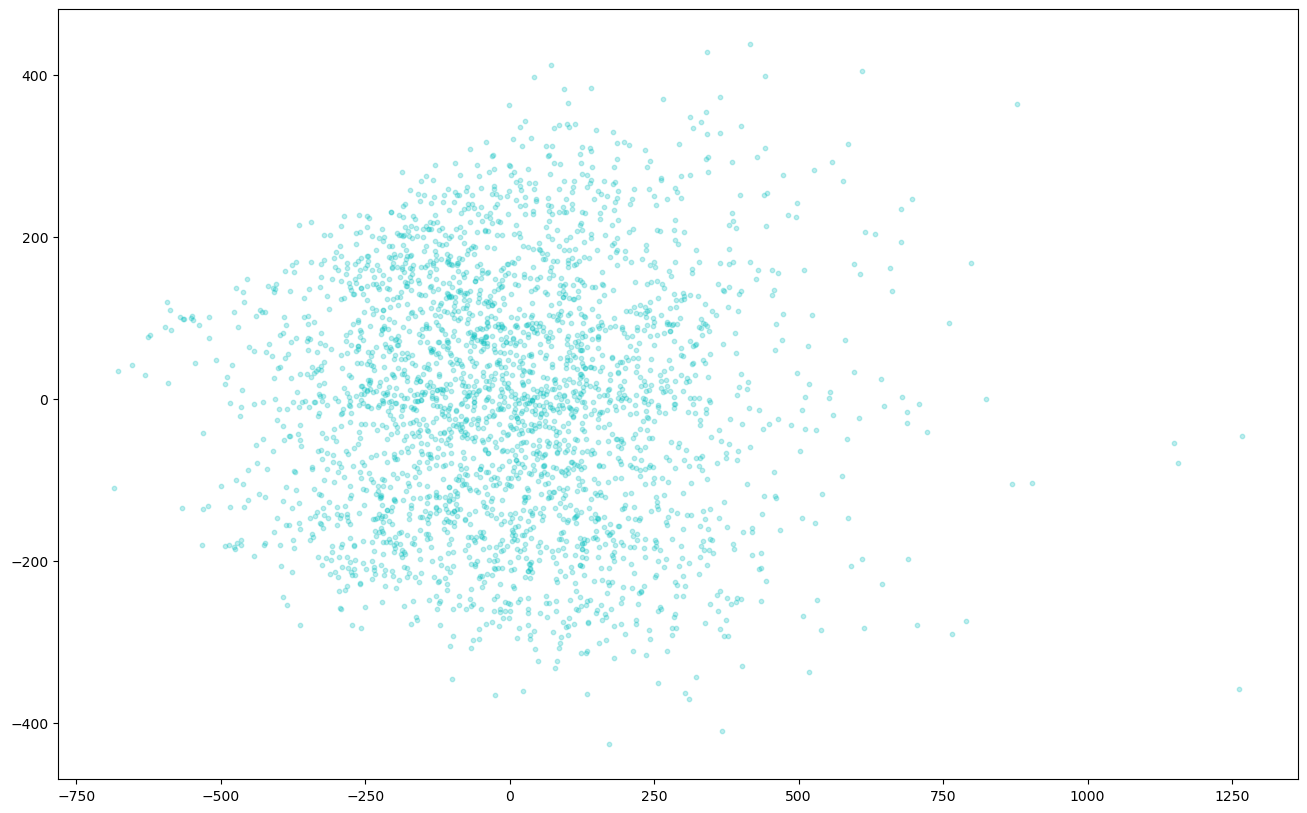

In [14]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

fig = plt.subplots(figsize=(16,10))
plt.scatter(x[:, 0], x[:, 1], s=10, c='c', alpha=0.25);
#Pas convaincant pour faire clusters ensuite

Réduction de dimension avec _Uniform Manifold Approximation and Projection for Dimension Reduction_ (UMAP)

/Users/lise/anaconda3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


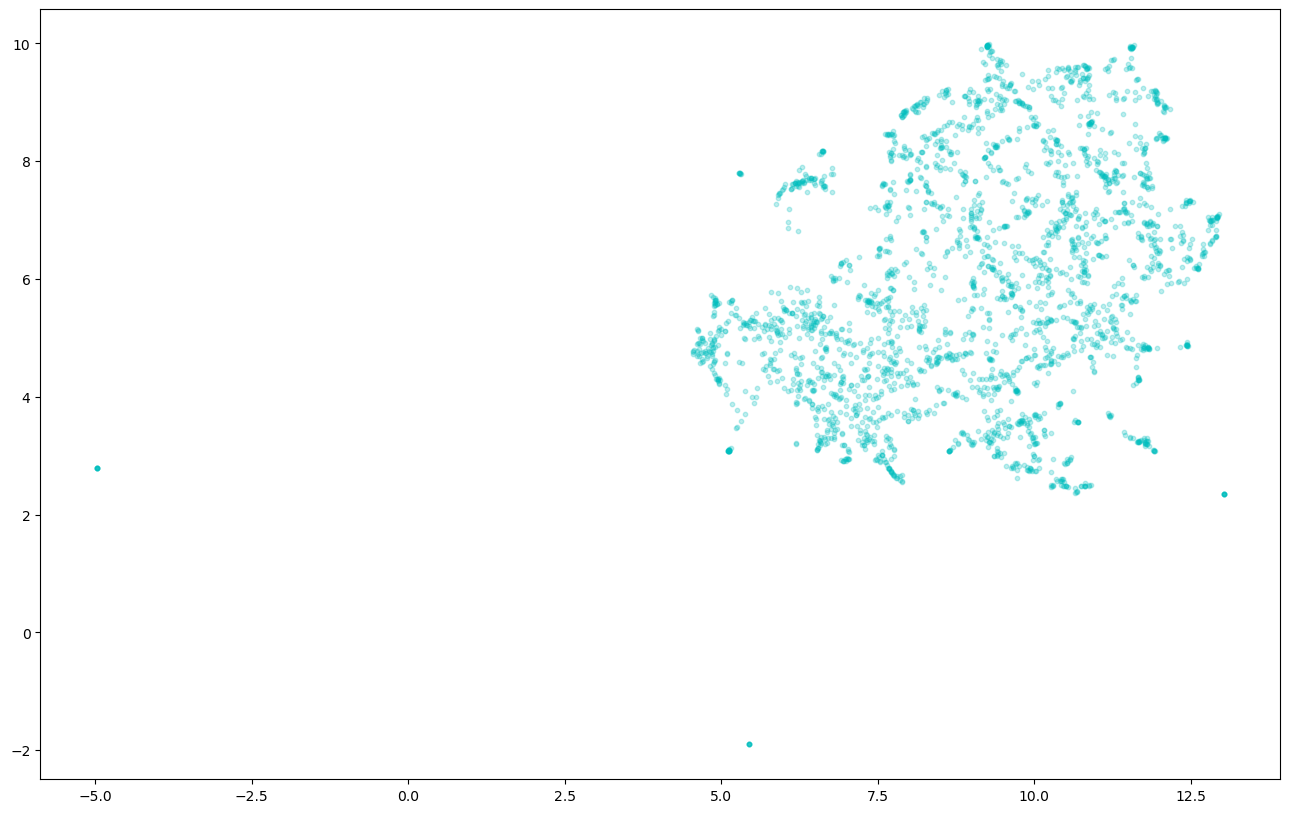

In [15]:
x = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(feat)

fig = plt.subplots(figsize=(16,10))
plt.scatter(x[:, 0], x[:, 1], s=10, c='c', alpha=0.25);

## Clustering. Deux méthodes : HDBSCAN et KMEANS

In [27]:
#Fonction permettant de visualiser les images dans les clusters
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    print("Nombre d'images dans le cluster :", len(files))
    # only allow up to 99 images to be shown at a time
    if len(files) > 99:
        print(f"Clipping cluster size from {len(files)} to 99")
        files = files[0:99]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        
#Fonction permettant de récupérer un dataframe contenant 
#les informations sur les objets associés aux images
def get_id_info(cluster) : 
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    files_list = []

    # plot each image in the cluster
    for index, file in enumerate(files):
        ID = file[0:6]
        files_list.append(ID)
        files_list_unique = list(set(files_list)) #On garde un seul identifiant (même si le cluster contient plusieurs fois le même objet)
    
    print("Nombre d'éléments dans le cluster :", len(files_list_unique))
    
    cluster_df = pd.DataFrame()
    for elt in files_list_unique :
        entry = df_textile_cluster.loc[df_textile_cluster['ID'] == f'ILCA_{elt}']
        cluster_df = pd.concat([cluster_df,entry])
    return cluster_df

### HDBSCAN
Permet de ne pas avoir à fournir un nombre de clusters.
#### Choix des paramètres : https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

- **min_cluster_size** : choix du plus petit nombre d'éléments que l'on considère comme composant un cluster
- **max_cluster_size** : choix du plus grand nombre d'éléments que l'on considère comme composant un cluster --> ne fonctionne pas
- **min_samples** : Détermine ce qui est du bruit et ce qui est élément des clusters (zone les plus denses). En l'augmentant, on augmente ce qui est considéré comme bruit. Par défaut, prend la même valeur que **min_cluster_samples**, le réduire permet de garder plus de clusters différents.
- **cluster_selection_epsilon** : permet de conserver des grands clusters dans les zones les plus denses (même si **min_cluster_size** faible)
- **alpha** : doc déconseille de l'utiliser, par défaut 1.0, en l'augmentant on augmente ce qui est considéré comme bruit mais à une échelle plus petite que **min_samples**.
- **allow_single_cluster** (bool) : pour essayer de récupérer un seul grand cluster

#### Tests : 
- Sans indiquer de paramètres, HDBSCAN organise les 3301 images en 159 clusters.
- min_samples=1 --> 266 clusters
- min_cluster_size=10, min_samples=1 --> 136 clusters
- min_samples=1, cluster_selection_epsilon=0.5 --> 9 clusters, dont le 8e qui contient 2852 images
- min_cluster_size=50,min_samples=1, cluster_selection_epsilon=0.5 --> 2 clusters : 1 de 372 et 1 de 2897
- min_cluster_size=10, min_samples=1, cluster_selection_epsilon=0.2 --> 19 clusters : 1 de 2582 éléments
- max_cluster_size=100, min_samples=1, cluster_selection_epsilon=0.2 --> 26 clusters


In [28]:
##Version HDBSCAN du package HDBSCAN
clustering = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, cluster_selection_epsilon=0.2).fit(x)

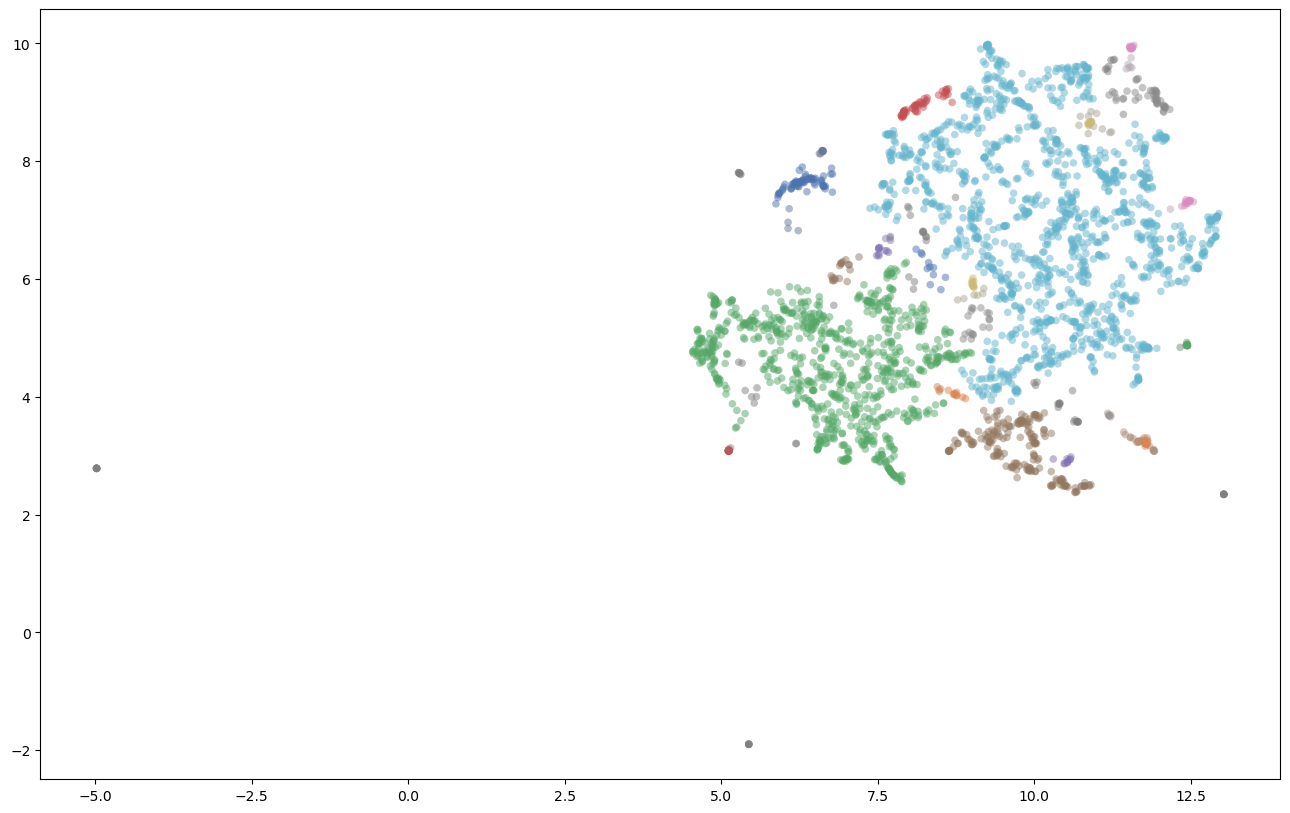

In [29]:
#Visalisation HDBSCAN
fig = plt.subplots(figsize=(16,10))
color_palette = sns.color_palette('deep', 30)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clustering.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clustering.probabilities_)]
plt.scatter(*x.T, s=30, linewidth=0, c=cluster_member_colors, alpha=0.5)

In [30]:
# holds the cluster id and the images { id: [images] }
i = 0
groups = {}
filenames = []

for file, cluster in zip(arraynames,clustering.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    if cluster == -1:
        filenames.append(file)
    i+=1

print(clustering.labels_)
print(set(clustering.labels_))

#Nombre de cluster : 
print("Nombre de clusters détectés :", len(set(clustering.labels_)))

[19 19  0 ... 19 12 19]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1}
Nombre de clusters détectés : 21


Nombre d'images dans le cluster : 78


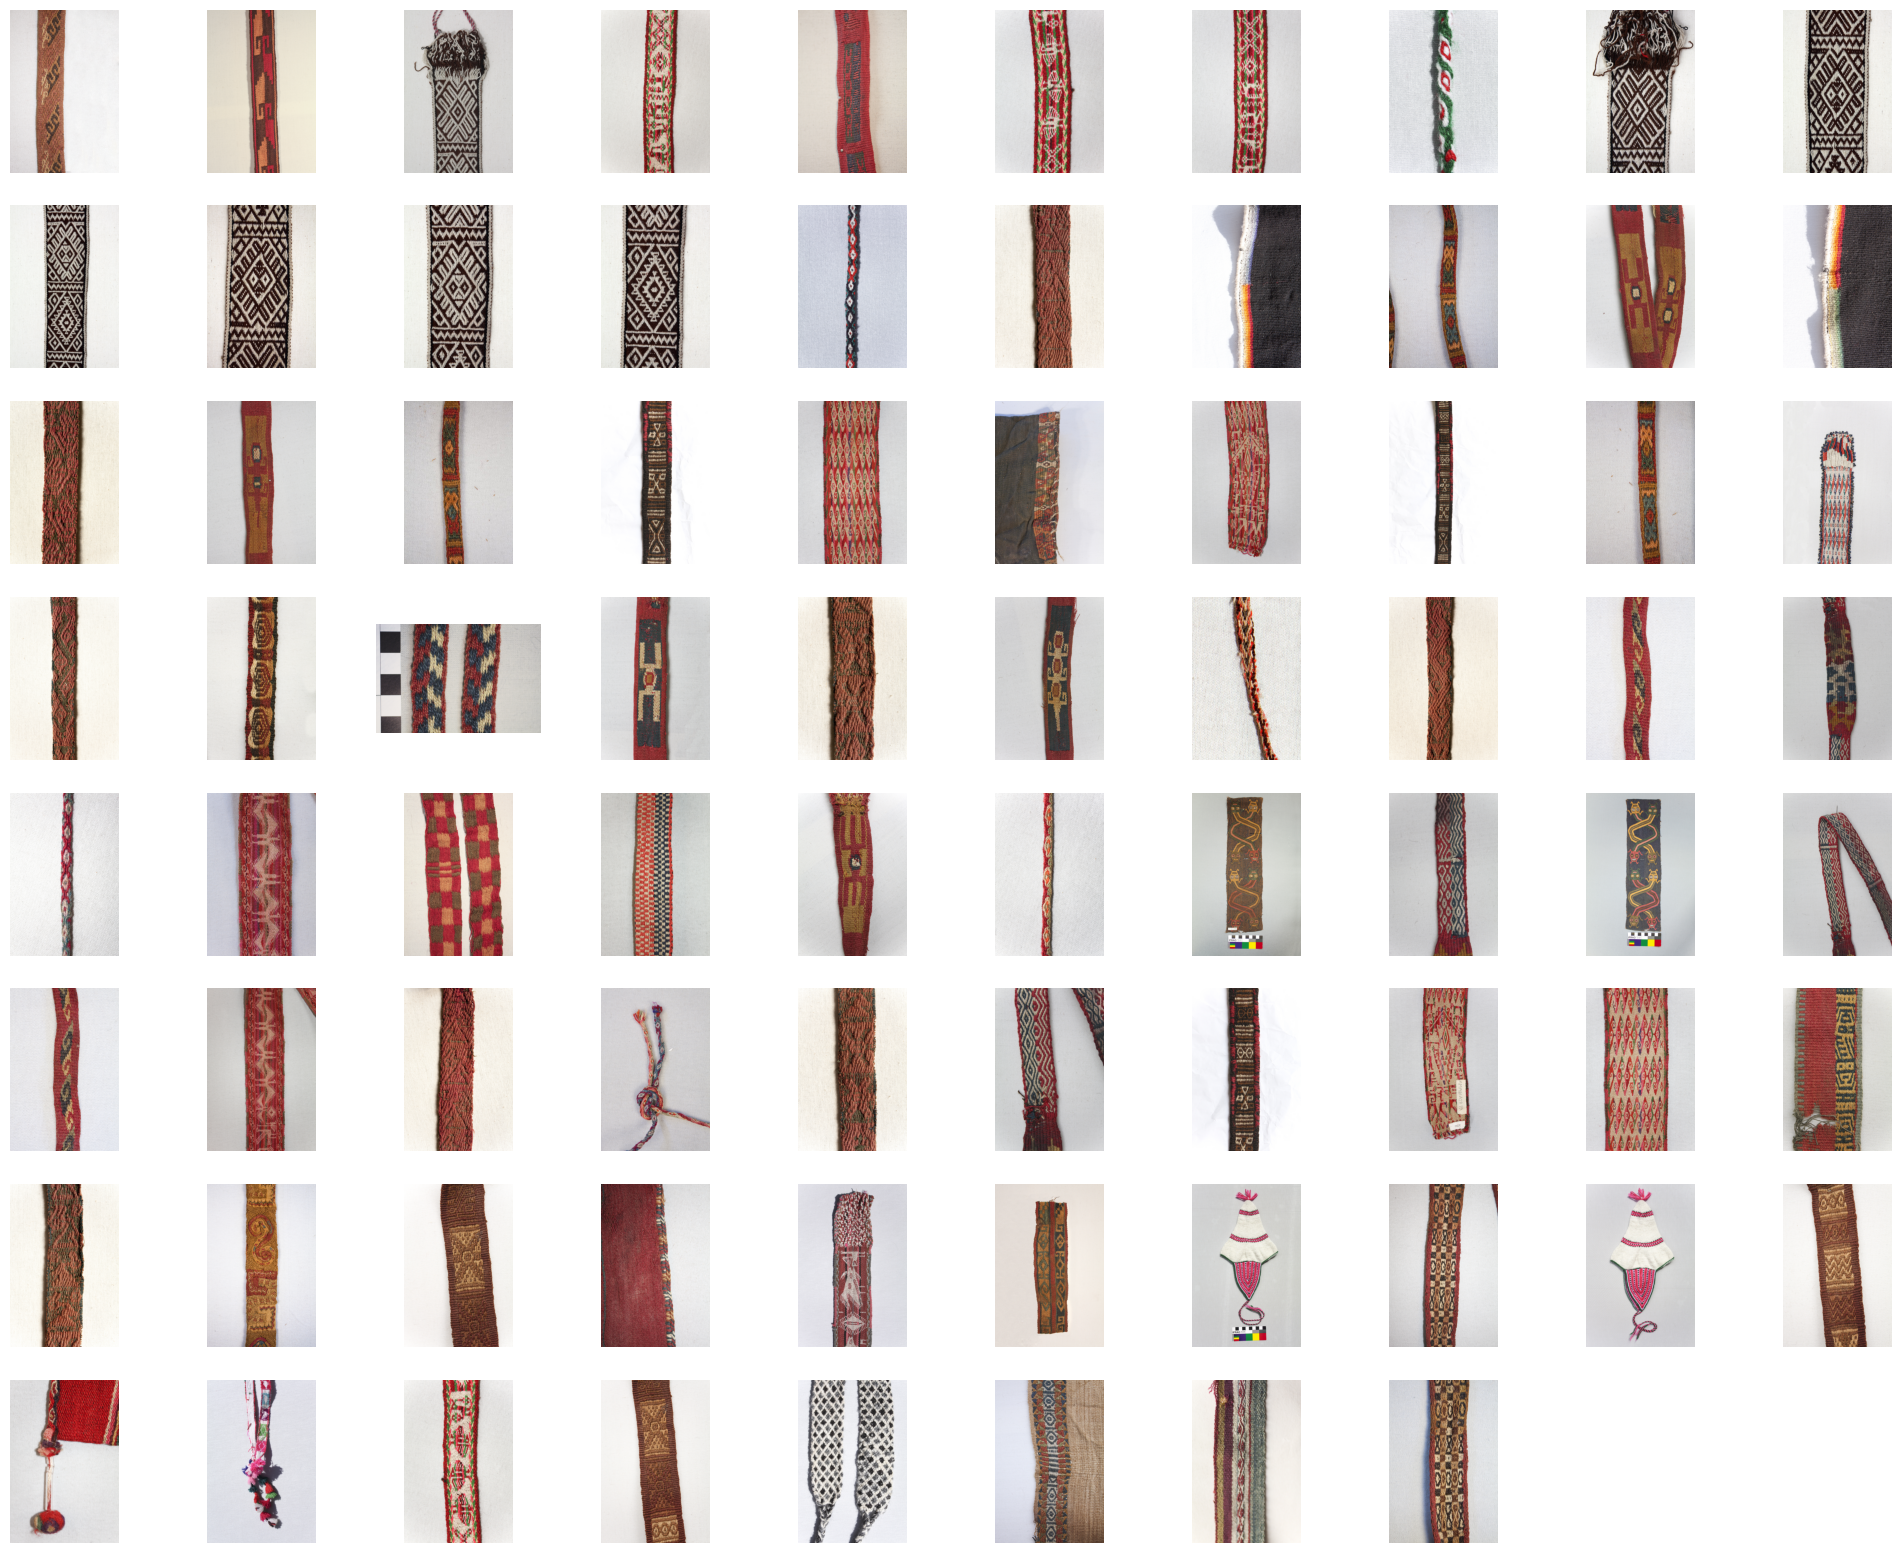

In [31]:
view_cluster(0)

In [32]:
get_id_info(0)

Nombre d'éléments dans le cluster : 35


ID                              period  \
671  ILCA_SPA012        Middle Horizon (600-1000 AD)   
117  ILCA_BML113         Late Horizon (1470-1535 AD)   
587  ILCA_MSF044         Late Horizon (1470-1535 AD)   
628  ILCA_MSF085    Republican Period (1825-present)   
10   ILCA_BML004        Middle Horizon (600-1000 AD)   
132  ILCA_BML131    Republican Period (1825-present)   
140  ILCA_BML139    Republican Period (1825-present)   
519  ILCA_MNA007    Republican Period (1825-present)   
584  ILCA_MSF041        Middle Horizon (600-1000 AD)   
143  ILCA_BML142    Republican Period (1825-present)   
139  ILCA_BML138    Republican Period (1825-present)   
542  ILCA_MNA040  Early Intermediate (200 BC-600 AD)   
599  ILCA_MSF056        Middle Horizon (600-1000 AD)   
114  ILCA_BML110         Late Horizon (1470-1535 AD)   
144  ILCA_BML143    Republican Period (1825-present)   
559  ILCA_MSF016        Middle Horizon (600-1000 AD)   
492  ILCA_MMA044         Late Horizon (1470-1535 AD)   
564  ILCA_MSF021    Late Intermediate (1000-1470 AD)   
593  ILCA_MSF050         Late Horizon (1470-1535 AD)   
568  ILCA_MSF025         Late Horizon (1470-1535 AD)   
71   ILCA_BML067         Late Horizon (1470-1535 AD)   
83   ILCA_BML080         Late Horizon (1470-1535 AD)   
694  ILCA_VAM027          Early Horizon (900-200 BC)   
146  ILCA_BML145    Republican Period (1825-present)   
562  ILCA_MSF019    Late Intermediate (1000-1470 AD)   
547  ILCA_MSF004    Late Intermediate (1000-1470 AD)   
569  ILCA_MSF026         Late Horizon (1470-1535 AD)   
578  ILCA_MSF035         Late Horizon (1470-1535 AD)   
13   ILCA_BML007        Middle Horizon (600-1000 AD)   

                                       production site  \
671         Atacama Basin, Chile, San Pedro de Atacama   
117                           Nasca, Peru, South coast   
587                          Arica, Arica coast, Chile   
628   Bolivia, Charazani, Northern Interandean Valleys   
10                            Nasca, Peru, South coast   
132       Bolivia, Caiza, Southern Interandean Valleys   
140   Bolivia, Charazani, Northern Interandean Valleys   
519  Bolivia, North Altiplano, Region of lake Titic...   
584                                  Peru, South coast   
143   Bolivia, Charazani, Northern Interandean Valleys   
139   Bolivia, Charazani, Northern Interandean Valleys   
542                         Paracas, Peru, South coast   
599                           Nasca, Peru, South coast   
114                          Arica, Arica coast, Chile   
144   Bolivia, Charazani, Northern Interandean Valleys   
559         Arica Interior, Chile, San Miguel de Azapa   
492                          Arica, Arica coast, Chile   
564                                Central coast, Peru   
593                                               Peru   
568                                  Peru, South coast   
71                                 Central coast, Peru   
83                         Chanchan, North coast, Peru   
694                         Paracas, Peru, South coast   
146                 Bolivia, Central Altiplano, Totora   
562                                  North coast, Peru   
547                                Central coast, Peru   
569                                 Peru, South sierra   
578                           Bolivia, North Altiplano   
13                            Nasca, Peru, South coast   

                                             find site  \
671                       Atacama Basin, Chile, Solcor   
117                           Nasca, Peru, South coast   
587                                                NaN   
628   Bolivia, Charazani, Northern Interandean Valleys   
10                          Paracas, Peru, South coast   
132              Bolivia, Southern Interandean Valleys   
140  Bolivia, Charazani-Sanipalla, Northern Interan...   
519  Bolivia, North Altiplano, Region of lake Titic...   
584                                                NaN   
143   Bolivi

<Figure size 2500x2500 with 0 Axes>

### KMEANS

In [33]:
# cluster feature vectors
clustering = KMeans(n_clusters=20, random_state=22).fit(x)

/Users/lise/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


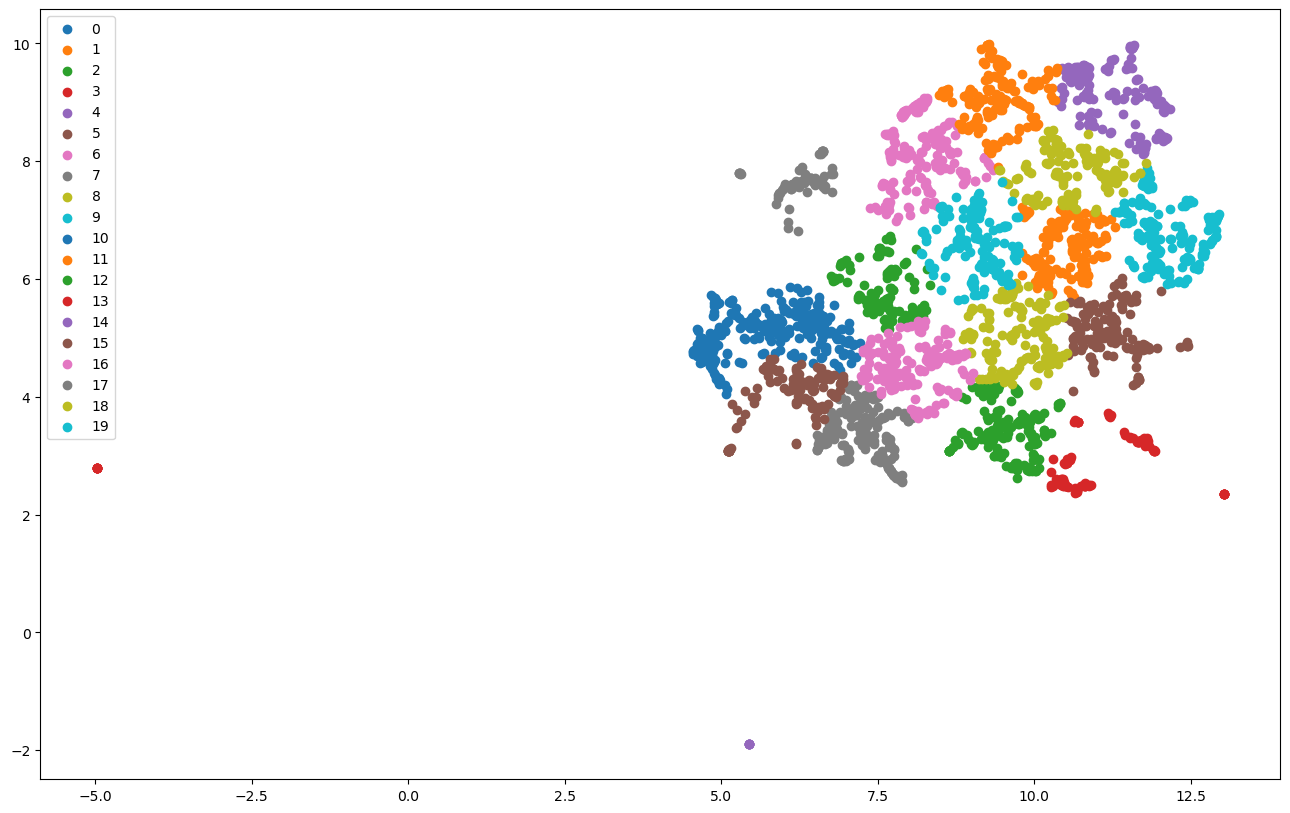

In [34]:
#Visualisation KMEANS
label = clustering.labels_
u_labels = np.unique(label)

plt.figure(figsize=(16,10))
 
#plotting the results:
for i in u_labels:
    plt.scatter(x[label == i , 0] , x[label == i , 1] , label = i)
plt.legend()
plt.show()

In [35]:
# holds the cluster id and the images { id: [images] }
i = 0
groups = {}
filenames = []

for file, cluster in zip(arraynames,clustering.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    if cluster == -1:
        filenames.append(file)
    i+=1

print(clustering.labels_)
print(set(clustering.labels_))

#Nombre de cluster : 
print("Nombre de clusters détectés :", len(set(clustering.labels_)))

[18  8 17 ... 11 16  6]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Nombre de clusters détectés : 20


Nombre d'images dans le cluster : 8


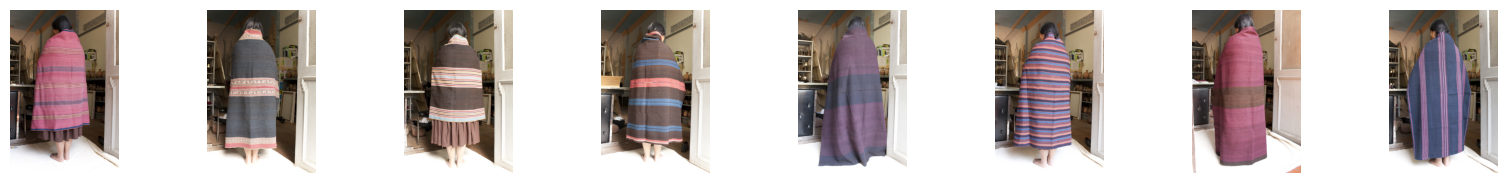

In [36]:
view_cluster(3)

In [37]:
get_id_info(3)

Nombre d'éléments dans le cluster : 8


ID                            period  \
532  ILCA_MNA029  Republican Period (1825-present)   
534  ILCA_MNA031    Colonial Period (1535-1824 AD)   
531  ILCA_MNA028    Colonial Period (1535-1824 AD)   
535  ILCA_MNA032  Republican Period (1825-present)   
530  ILCA_MNA027    Colonial Period (1535-1824 AD)   
536  ILCA_MNA033  Republican Period (1825-present)   
537  ILCA_MNA034  Republican Period (1825-present)   
529  ILCA_MNA026  Republican Period (1825-present)   

                                      production site  \
532                         Acora, Peru, South sierra   
534        Bolivia, Jesús de Machaqa, North Altiplano   
531                  Bolivia, Escoma, North Altiplano   
535     Bolivia, Bolívar, Central Interandean Valleys   
530                         Acora, Peru, South sierra   
536  Bolivia, Southern Interandean Valleys, Toropalca   
537               Bolivia, Calamarca, North Altiplano   
529  Bolivia, Southern Interandean Valleys, Toropalca   

                                            find site  \
532                         Acora, Peru, South sierra   
534                  Bolivia, La Paz, North Altiplano   
531                  Bolivia, Escoma, North Altiplano   
535     Bolivia, Bolívar, Central Interandean Valleys   
530                         Acora, Peru, South sierra   
536  Bolivia, Southern Interandean Valleys, Toropalca   
537                  Bolivia, La Paz, North Altiplano   
529  Bolivia, Southern Interandean Valleys, Toropalca   

                                  repository  \
532  National Archaeological Museum, website   
534  National Archaeological Museum, website   
531  National Archaeological Museum, website   
535  National Archaeological Museum, website   
530  National Archaeological Museum, website   
536  National Archaeological Museum, website   
537  National Archaeological Museum, website   
529  National Archaeological Museum, website   

                                  culture            fabric  
532  Aymara-Uru-Lupaqa, Aymara-Uru-Lupaca  Warp-faced cloth  
534                  Aymara-North Pacajes  Warp-faced cloth  
531                       Aymara-Omasuyos  Warp-faced cloth  
535                   Quechua-Charcas sur  Warp-faced cloth  
530  Aymara-Uru-Lupaqa, Aymara-Uru-Lupaca  Warp-faced cloth  
536              Quechua-South Qharaqhara  Warp-faced cloth  
537                  Aymara-North Pacajes  Warp-faced cloth  
529              Quechua-South Qharaqhara  Warp-faced cloth

<Figure size 2500x2500 with 0 Axes>